# Temperature Profile Classification - 2 Class system - r3_v2
GMM classification of Southern Ocean Argo float temperature profile data. This notebook uses a previously created model, PCA and sample data.<br><br>

### Choices for data

In [1]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceId = 'UKESM1-0-LL'
dataInstitutionId = 'MOHC'
approvedIds = ["r1i1p1f2", "r2i1p1f2", "r3i1p1f2"] #insert start of approved member_ids

#File imports
maskName = "OceanMaskVolcello"
modelName = "GMM_UK_2Class_R3_v2"

#Data definitions
startDate = '1980-01'
endDate = '2009-12'
timeRange = slice(startDate, endDate)
levSel = slice(0, 2000) #Selected levels to be investigated
maxLat = -30 #Selected latitude to be investigated

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [2]:
#Import cell
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import config
from dask import delayed
from joblib import dump, load
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy import signal

config.set(**{'array.slicing.split_large_chunks': True})
print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [3]:
importName = modelName + "_Meta_Full"
sampleMetaDFL = pd.read_csv(importName)
sampleMetaDFL = sampleMetaDFL.drop(columns=["Unnamed: 0"])
sampleMetaDFL["time"] = pd.to_datetime(sampleMetaDFL["time"])
print("Labeled sample meta data loaded from "+ importName +" and stored in sampleMetaDFL. "+ str(len(sampleMetaDFL)) +" samples loaded.")
sampleMetaDFL.head()

Labeled sample meta data loaded from GMM_UK_2Class_R3_v2_Meta_Full and stored in sampleMetaDFL. 7989840 samples loaded.


lat   lon       time  labelSorted  max posterior prob  \
0 -66.111520  73.5 1980-01-01            0                 1.0   
1 -65.703316  73.5 1980-01-01            0                 1.0   
2 -65.288570  73.5 1980-01-01            0                 1.0   
3 -64.867195  73.5 1980-01-01            0                 1.0   
4 -64.439100  73.5 1980-01-01            0                 1.0   

   classUncertainty  
0      6.178388e-09  
1      2.965486e-10  
2      5.714185e-11  
3      3.317169e-11  
4      3.678746e-11

In [4]:
#Meta data date processing cell
globalStartDate = sampleMetaDFL["time"][0]
globalDateInc = sampleMetaDFL["time"].unique()[1] - globalStartDate
globalEndDateIn = sampleMetaDFL["time"].iloc[-1]
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]
print("Sample meta data dates manipulated and stored in globalStartDate etc.")

Sample meta data dates manipulated and stored in globalStartDate etc.


<br>
<b>Loading ocean Masks</b>

In [5]:
#Ocean mask import cell
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
maskFile = xr.open_dataset("OceanMaskUKESM1")
oceanMask2 = maskFile.to_array()
print("Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).")

Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).


<br>
<b>Unpacking ocean masks</b>

In [6]:
#Mask unpacking cell
geoRange = oceanMask #copying mask
geoRange = geoRange.rename({"variable":"cleanMe"}) #Dimension removal
geoRange = geoRange.sel(cleanMe = geoRange.cleanMe.values[0]) #Dimension removal
geoRange = geoRange.reset_coords("cleanMe", drop=True) #Dimension removal
geoRangeS = geoRange.stack(ij =("i", "j")) #Stacking
geoRangeFilt = geoRangeS.dropna("ij")
print("Ocean mask unpacked into geoRangeFilt.")

geoRange2 = oceanMask2 #copying mask
geoRange2S = geoRange2.stack(ij =("i", "j")) #Stacking
geoRangeFilt2 = geoRange2S.dropna("ij")
print("UKESM Ocean mask unpacked into geoRangeFilt2.")

Ocean mask unpacked into geoRangeFilt.
UKESM Ocean mask unpacked into geoRangeFilt2.


<br>
<b>Date Calculations</b>

In [7]:
#Date calculation cell
startDateNp = np.datetime64(startDate, 'M')
endDateNp = np.datetime64(endDate, 'M')
timeDiff = endDateNp - startDateNp
timeDiff = timeDiff.astype(int) + 1
print("Calculated date range.")

Calculated date range.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
<li> butter_lowpass - Returns a filtered version of the input array using a butterworth filter
</ul>

In [8]:
#Calculation functions cell
def butter_lowpass(data,cut,order=4,sample_freq=1) :
    nyq = 0.5*sample_freq
    pass_freq =1./cut/nyq
    sos=signal.butter(order, pass_freq, 'low', output='sos')
    filt=signal.sosfiltfilt(sos,data)
    return filt

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li> locationPlotGroup - plots location and classification of data points for an input numpy array.
<li> locationPlotGroupDFLab - plots location and classification of data points for a provided data frame.
<li> locationPlotGroupDFMonthly - plots location and classification of data points for an input data frame in monthly subplots.
<li> locationPlotGroupDFTime - plots mean classification of data points for an input data frame.
<li> locationPlotTime - plots locations of an input data array on a map with a colour scale for time.
<li> locationPlotUncertaintyDF - plots uncertainty in classification on a location plot.
<li> locationPlotUncertaintyDFMonthly - plots location and uncertainty of data points for an input data frame in monthly subplots.
<li> locationPlotXr - plots dataframe/xr data locations (used for masks)
<li> locationUncertaintyMean - plots mean latitude per longitude +-1 standard deviation on orthogonal plot
<li> locationUncertaintyMeanCart - plots mean latitude per longitude +-1 standard deviation on standard plot
<li> timeSingleLatMean - plots mean singular latitude over time on standard plot
</ul>

In [9]:
#Plotting functions Cell
#sampleDepthAxis = dfESMLatLevT["lev"]
decadeColours = ["#CC6677", "#DDCC77", "#117733"]
timeList = sampleMetaDFL["time"].unique()

def locationPlotGroup(metaDataArray, size, plotNo):
    '''Plots locations of numpy arrays with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(metaDataArray[1], metaDataArray[0], transform=ccrs.PlateCarree(), c =  metaDataArray[3], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Grouped Sample Locations ("+str(len(metaDataArray[0]))+")")
 
    
def locationPlotGroupDFLab(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["labelSorted"], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotGroupDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        #timeData = dataFrame.where(dataFrame["time"].dt.month==i) #normal dt info
        timeData = dataFrame.where(dataFrame["time"] ==i) #groupby dt info
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["labelSorted"], cmap='RdBu_r')
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")
    

def locationPlotGroupDFTime(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  mdates.date2num(dataFrame["time"]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotTime(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")


def locationPlotUncertaintyDF(dataFrame, title, size, plotNo):
    '''Plots input data array classification uncertainties'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotUncertaintyDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        #timeData = dataFrame.where(dataFrame["time"].dt.month==i) #normal dt info
        timeData = dataFrame.where(dataFrame["time"] ==i) #groupby dt info
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
        #cb = plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotXr(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray["lon"], dataArray["lat"], transform=ccrs.PlateCarree())
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray["lat"]))+")")        

    
def locationUncertaintyMean(decadeMeanList, decadeStdList, uncertaintyThreshold, figSize, plotNo):
    '''Plots mean latitude for classification uncertainty with +- 1 std on a map'''
    plt.figure(plotNo, figsize=figSize)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    for i in range(len(decadeMeanList)):
        ax.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"], transform=ccrs.PlateCarree(), color=decadeColours[i], label = decades[i])
        ax.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"] + decadeStdList[i]["lat"], transform=ccrs.PlateCarree(), color=decadeColours[i], ls = "--", lw = 0.75)
        ax.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"] - decadeStdList[i]["lat"], transform=ccrs.PlateCarree(), color=decadeColours[i], ls = "--", lw = 0.75)   
    ax.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Classification Uncertainty above "+str(uncertaintyThreshold)+" Mean Latitude")
    plt.legend()
    

def locationUncertaintyMeanCart(decadeMeanList, decadeStdList, uncertaintyThreshold, figSize, plotNo):
    '''Plots mean latitude for classification uncertainty with +- 1 std as a standard plot'''
    plt.figure(plotNo, figsize=figSize)
    for i in range(len(decadeMeanList)):
        plt.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"], color=decadeColours[i], label = decades[i])
        plt.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"] + decadeStdList[i]["lat"], color=decadeColours[i], ls = "--", lw = 1)
        plt.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"] - decadeStdList[i]["lat"], color=decadeColours[i], ls = "--", lw = 1)
    plt.title("Classification Uncertainty above "+str(uncertaintyThreshold)+" Mean Latitude")
    plt.legend()


def timeSingleLatMean(meanLatArr, lineStyle , arrThreshold, arrSmoothFact, plotNo):
    '''Plots singlular Latitude mean on standard plot'''
    plt.figure(plotNo, figsize=(20,10))
    plt.plot(timeList, meanLatArr, lw=1, ls=lineStyle ,label="Thresh_"+str(arrThreshold)+"_smooth"+str(arrSmoothFact))
    plt.xlabel("Date")
    plt.ylabel("Singular Mean Latitude")
    plt.title("Classification Uncertainty Mean Latitude over time")
    plt.legend()
    
    
print("Plotting functions defined.")

Plotting functions defined.


<br>

### Plotting Ocean Mask

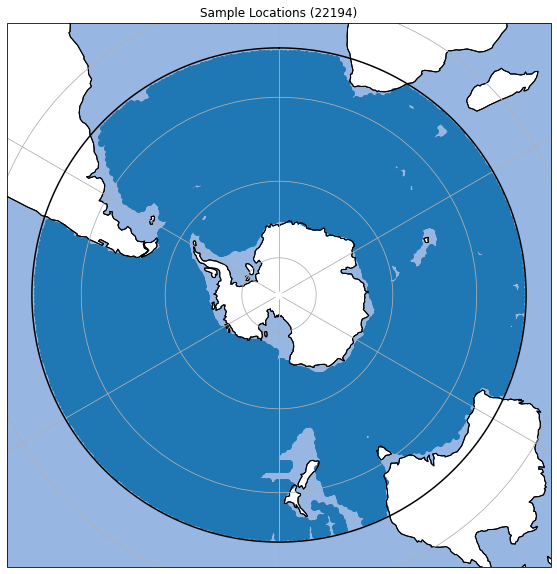

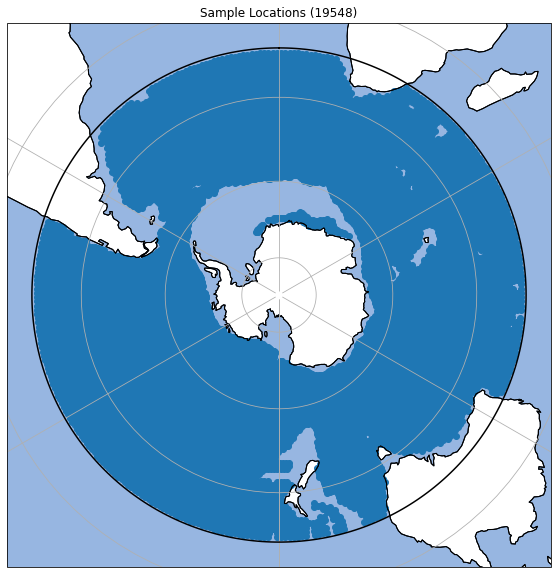

In [10]:
#Mask plotting cell
locationPlotXr(geoRangeFilt, (10,10), 1) #OceanMaskVolcello
locationPlotXr(geoRangeFilt2, (10,10), 2) #OceanMaskUKESM1
plt.show()

<br>

### Anomalies

In [11]:
#Initial anomalous data point df creation cell
labelAnomDF = sampleMetaDFL[np.logical_or(np.logical_and(sampleMetaDFL["lat"]<-60, sampleMetaDFL["labelSorted"]==1), np.logical_and(sampleMetaDFL["lat"]>-45, sampleMetaDFL["labelSorted"]==0))]
print("Class 0 above -45 and Class 1 below -60 lat. Stored in labelAnomDF. "+str(len(labelAnomDF))+" anomalous points detected.")

Class 0 above -45 and Class 1 below -60 lat. Stored in labelAnomDF. 2161 anomalous points detected.


In [12]:
#High confidence anomalous data point df creation cell
labelAnomConDF = labelAnomDF[labelAnomDF["classUncertainty"]<0.25]
print("High Classification Confidence DF of labelAnomDF (<0.25). "+str(len(labelAnomConDF))+" anomalous points detected.")

High Classification Confidence DF of labelAnomDF (<0.25). 300 anomalous points detected.


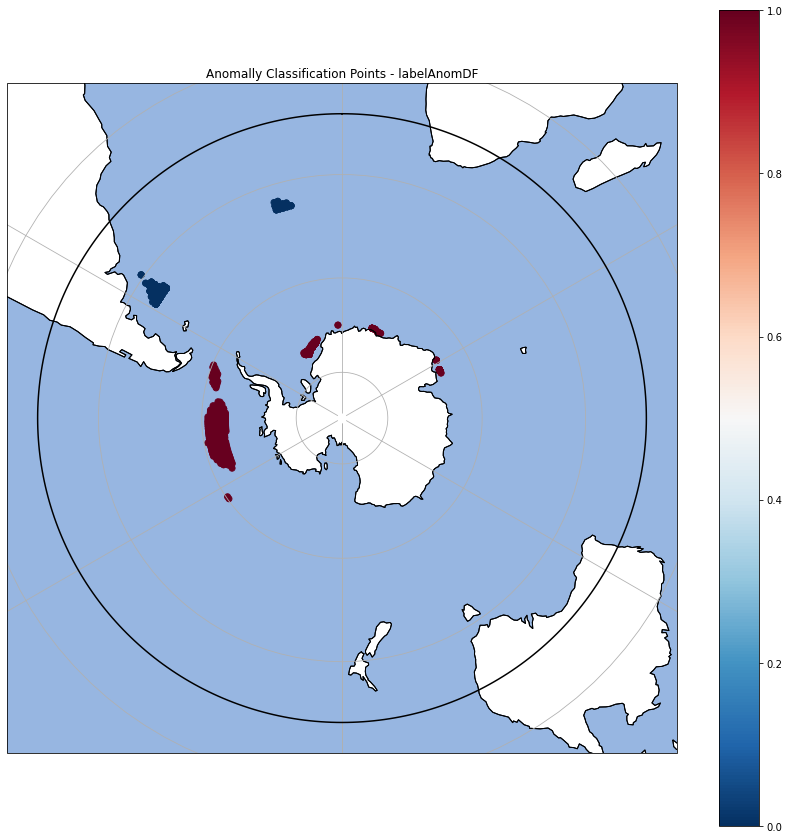

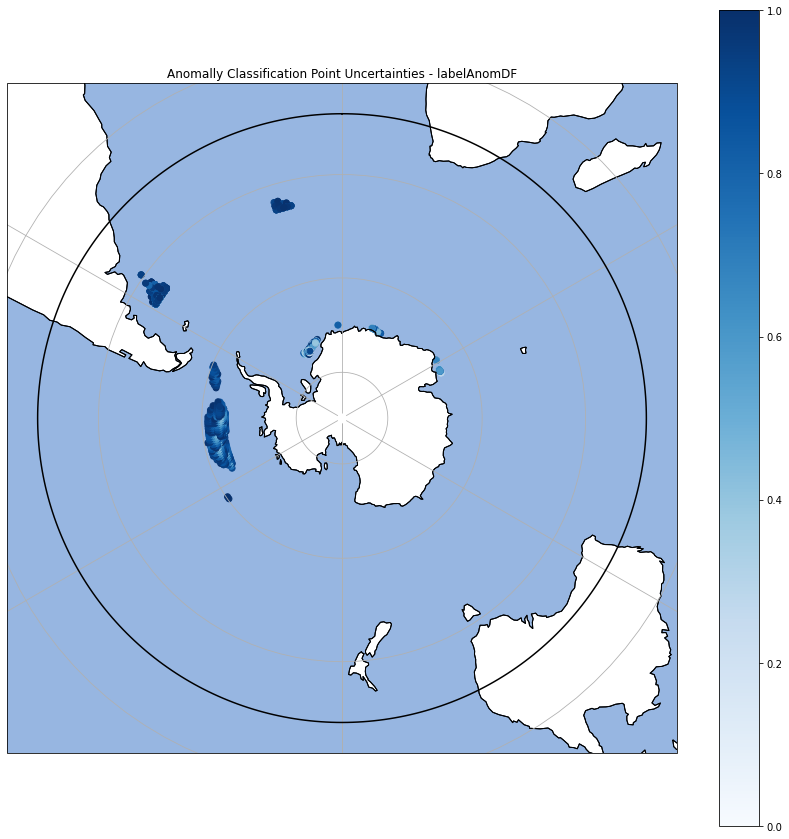

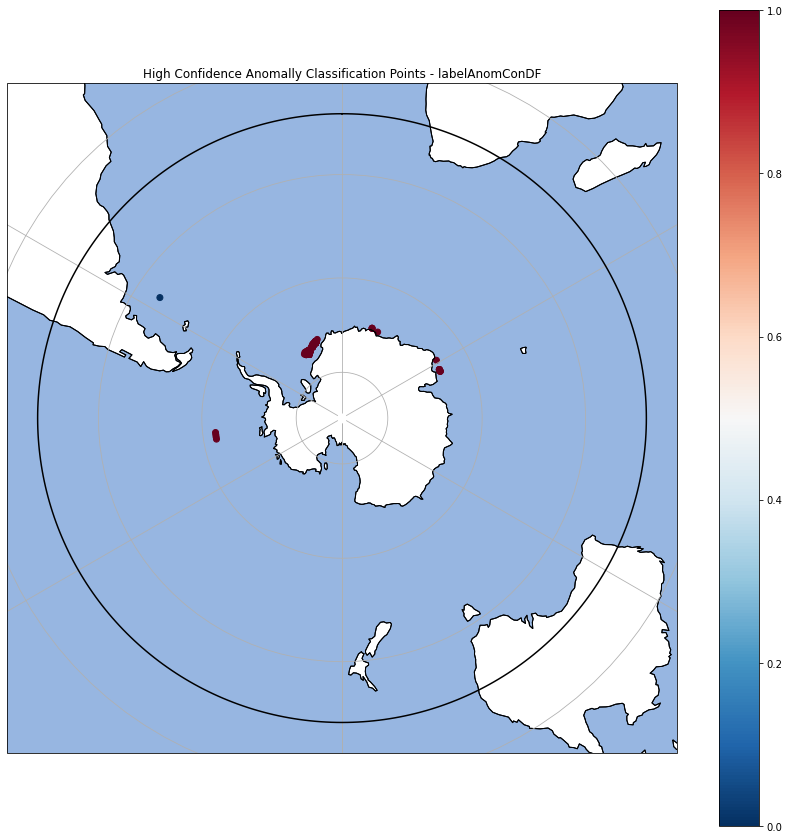

In [13]:
locationPlotGroupDFLab(labelAnomDF, "Anomally Classification Points - labelAnomDF", (15,15), 1)
locationPlotUncertaintyDF(labelAnomDF, "Anomally Classification Point Uncertainties - labelAnomDF", (15,15), 2)
locationPlotGroupDFLab(labelAnomConDF, "High Confidence Anomally Classification Points - labelAnomConDF", (15,15), 3)
plt.show()

<br>
<b>Antarctic Anomalous Classifications</b>

702 anomalous samples found. (Lat<-65, Lon<70, Lon>-60)


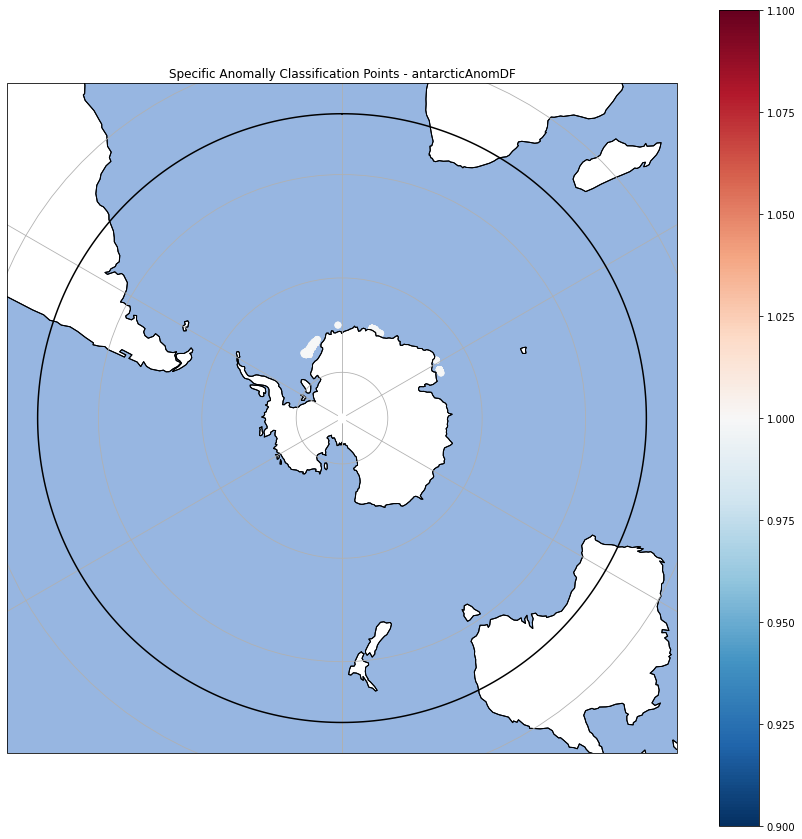

In [14]:
antarcticAnomDF = sampleMetaDFL[np.logical_and(np.logical_and(sampleMetaDFL["labelSorted"]==1, sampleMetaDFL["lat"]<-65), np.logical_and(sampleMetaDFL["lon"]>-60, sampleMetaDFL["lon"]<70))]
locationPlotGroupDFLab(antarcticAnomDF, "Specific Anomally Classification Points - antarcticAnomDF", (15,15), 1)
print(str(len(antarcticAnomDF))+" anomalous samples found. (Lat<-65, Lon<70, Lon>-60)")
plt.show()

<br>
<b>Antarctic Anomalous Classification Uncertainty</b>

1215 anomalous samples found. (Lat<-65, Lon<70, Lon>-60)


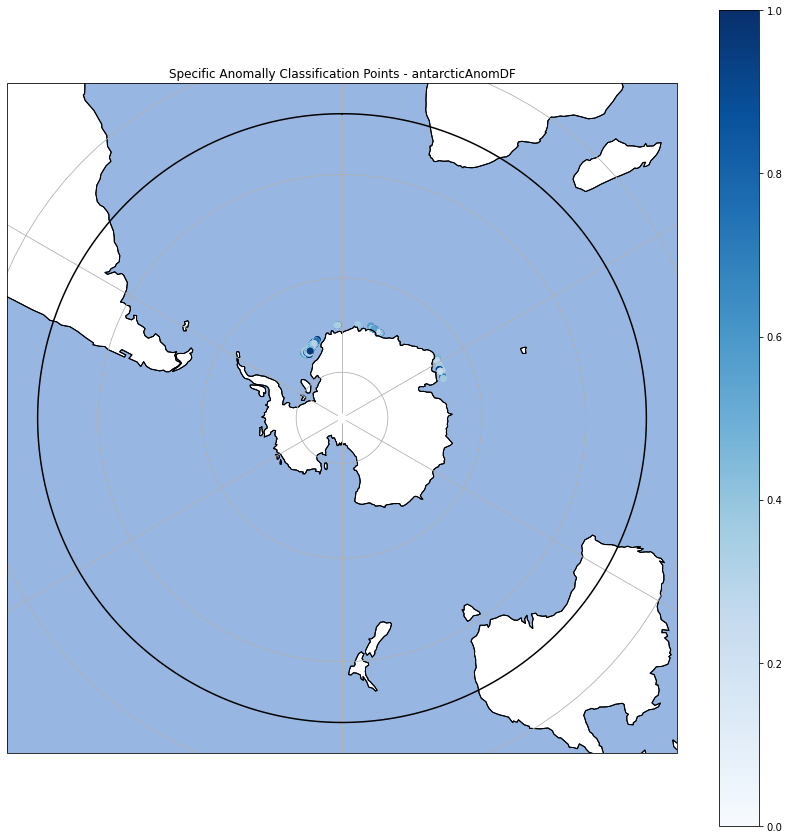

In [15]:
antarcticUncertDF = sampleMetaDFL[np.logical_and(np.logical_and(sampleMetaDFL["classUncertainty"]>=0.25, sampleMetaDFL["lat"]<-65), np.logical_and(sampleMetaDFL["lon"]>-60, sampleMetaDFL["lon"]<70))]
locationPlotUncertaintyDF(antarcticUncertDF, "Specific Anomally Classification Points - antarcticAnomDF", (15,15), 1)
print(str(len(antarcticUncertDF))+" anomalous samples found. (Lat<-65, Lon<70, Lon>-60)")
plt.show()

<br>
<b>South-East Pacific Classifications</b>

714 anomalous samples found. (Lat<-61, Lon<-60, Lon>-140)


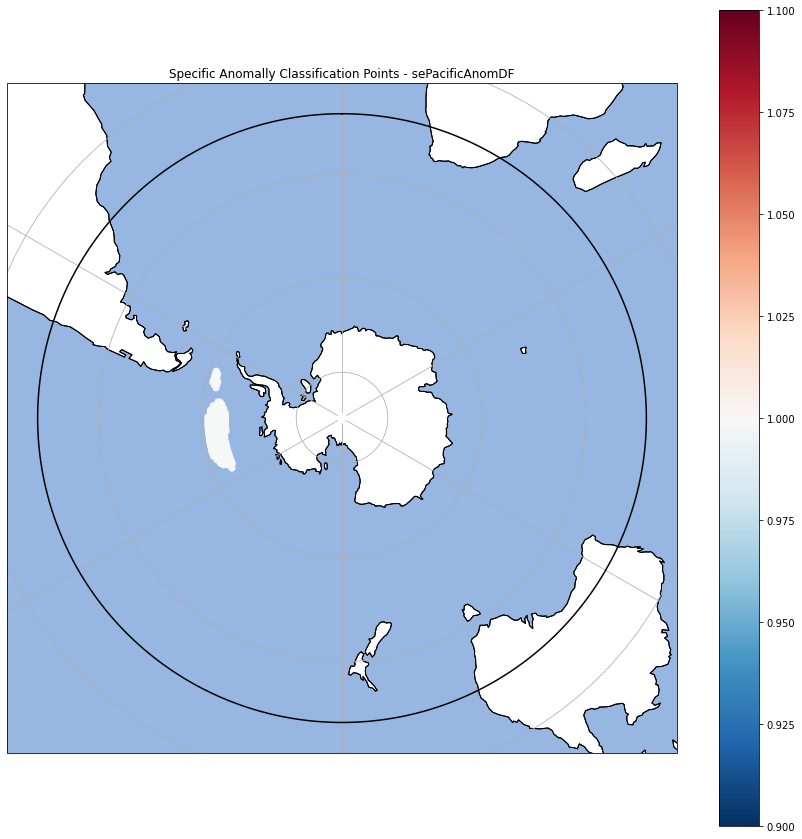

In [16]:
sePacificAnomDF = sampleMetaDFL[np.logical_and(np.logical_and(sampleMetaDFL["labelSorted"]==1, sampleMetaDFL["lat"]<-61), np.logical_and(sampleMetaDFL["lon"]>-140, sampleMetaDFL["lon"]<-60))]
locationPlotGroupDFLab(sePacificAnomDF, "Specific Anomally Classification Points - sePacificAnomDF", (15,15), 1)
print(str(len(sePacificAnomDF))+" anomalous samples found. (Lat<-61, Lon<-60, Lon>-140)")
plt.show()

In [17]:
print("South-East Pacific Anomaly Count (Lat<-61, Lon<-60, Lon>-140)")
sePacificAnomDF.groupby("time")["labelSorted"].value_counts()

South-East Pacific Anomaly Count (Lat<-61, Lon<-60, Lon>-140)


time        labelSorted
1981-02-01  1               16
1986-10-01  1               26
1986-11-01  1               30
1986-12-01  1                8
1989-09-01  1               76
1989-10-01  1              110
1989-11-01  1              120
1989-12-01  1               96
1990-01-01  1               51
1990-02-01  1               34
2001-02-01  1                3
2003-09-01  1               25
2003-10-01  1               53
2003-11-01  1               56
2003-12-01  1               10
Name: labelSorted, dtype: int64

<br>
<b>South-East Pacific Classification Uncertainties</b>

3987 anomalous samples found. (Lat<-62, Lon<-60, Lon>-140)


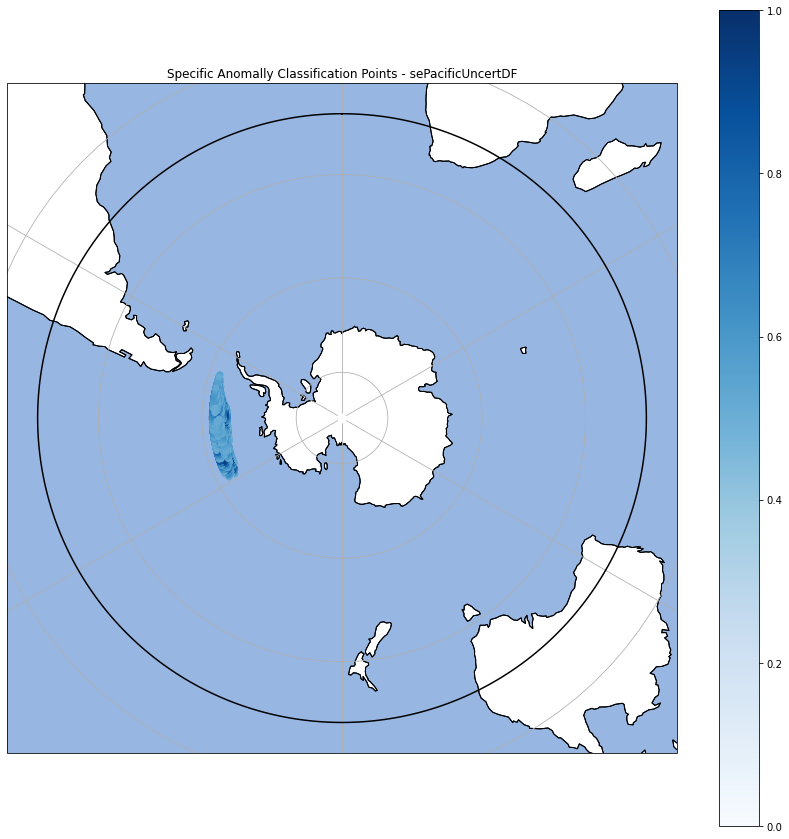

In [18]:
timeRange = np.arange(np.datetime64("1980-01"), np.datetime64("2000-01"), np.timedelta64(1, 'M'), dtype='datetime64[M]')

sePacificUncertDF = sampleMetaDFL[np.logical_and(np.logical_and(sampleMetaDFL["classUncertainty"]>=0.50, sampleMetaDFL["lat"]<-62), np.logical_and(sampleMetaDFL["lon"]>-140, sampleMetaDFL["lon"]<-60))]
locationPlotUncertaintyDF(sePacificUncertDF, "Specific Anomally Classification Points - sePacificUncertDF", (15,15), 1)
print(str(len(sePacificUncertDF))+" anomalous samples found. (Lat<-62, Lon<-60, Lon>-140)")
plt.show()

In [19]:
i = 0
sePacificUncertStack = sePacificUncertDF.groupby("time")["time"].value_counts()
print("South-East Pacific Uncertainty Count (Lat<-62, Lon<-60, Lon>-140)")
print("Time\t\t", "Count")
for x in sePacificUncertStack:
    strIndex = str(sePacificUncertStack.index[i])
    print(strIndex[12:22]+"\t", x)
    i +=1

South-East Pacific Uncertainty Count (Lat<-62, Lon<-60, Lon>-140)
Time		 Count
1980-01-01	 120
1980-02-01	 91
1980-03-01	 25
1980-09-01	 44
1980-10-01	 60
1980-11-01	 23
1980-12-01	 12
1981-01-01	 77
1981-02-01	 109
1981-03-01	 59
1985-10-01	 4
1986-09-01	 40
1986-10-01	 82
1986-11-01	 96
1986-12-01	 71
1987-01-01	 75
1987-02-01	 76
1987-03-01	 60
1987-04-01	 30
1987-05-01	 2
1987-08-01	 9
1987-09-01	 59
1987-10-01	 46
1987-11-01	 3
1989-08-01	 92
1989-09-01	 146
1989-10-01	 159
1989-11-01	 143
1989-12-01	 137
1990-01-01	 117
1990-02-01	 98
1990-03-01	 79
1990-04-01	 60
1990-05-01	 49
1990-06-01	 35
1990-07-01	 34
1990-08-01	 24
1990-09-01	 23
1994-02-01	 23
1997-01-01	 13
1997-02-01	 85
1997-03-01	 20
2000-09-01	 76
2000-10-01	 81
2000-11-01	 56
2000-12-01	 51
2001-01-01	 107
2001-02-01	 112
2001-03-01	 86
2001-04-01	 34
2003-09-01	 150
2003-10-01	 166
2003-11-01	 136
2003-12-01	 100
2004-01-01	 75
2004-02-01	 62
2004-03-01	 24
2006-09-01	 15
2006-10-01	 26
2006-11-01	 18
2007-02-01	 

<br>

### Data Readjustment

In [20]:
preAdLen = len(sampleMetaDFL)
if True:
    sampleMetaDFL = pd.concat([sampleMetaDFL, antarcticAnomDF, antarcticAnomDF]).drop_duplicates(keep=False)
    print("Removing antarcticAnomDF.")
    sampleMetaDFL = pd.concat([sampleMetaDFL, antarcticUncertDF, antarcticUncertDF]).drop_duplicates(keep=False)
    print("Removing antarcticUncertDF.")
    sampleMetaDFL = pd.concat([sampleMetaDFL, sePacificAnomDF, sePacificAnomDF]).drop_duplicates(keep=False)
    print("Removing sePacificAnomDF.")
    sampleMetaDFL = pd.concat([sampleMetaDFL, sePacificUncertDF, sePacificUncertDF]).drop_duplicates(keep=False)
    print("Removing sePacificUncertDF.\n")

postAdLen = len(sampleMetaDFL)
lenDiff = preAdLen - postAdLen
print("SampleMetaDFL adjusted from "+str(preAdLen)+" to "+str(postAdLen)+". "+str(lenDiff)+" samples dropped.")

Removing antarcticAnomDF.
Removing antarcticUncertDF.
Removing sePacificAnomDF.
Removing sePacificUncertDF.

SampleMetaDFL adjusted from 7989840 to 7984130. 5710 samples dropped.


In [21]:
print("Last data point in set (expected 2009-12):")
sampleMetaDFL.iloc[-1]

Last data point in set (expected 2009-12):


lat                            -30.455408
lon                             72.500000
time                  2009-12-01 00:00:00
labelSorted                             1
max posterior prob               1.000000
classUncertainty                 0.000000
Name: 7989839, dtype: object

Class 0 above -45 and Class 1 below -60 lat. Stored in labelAnomDF. 745 anomalous points detected.


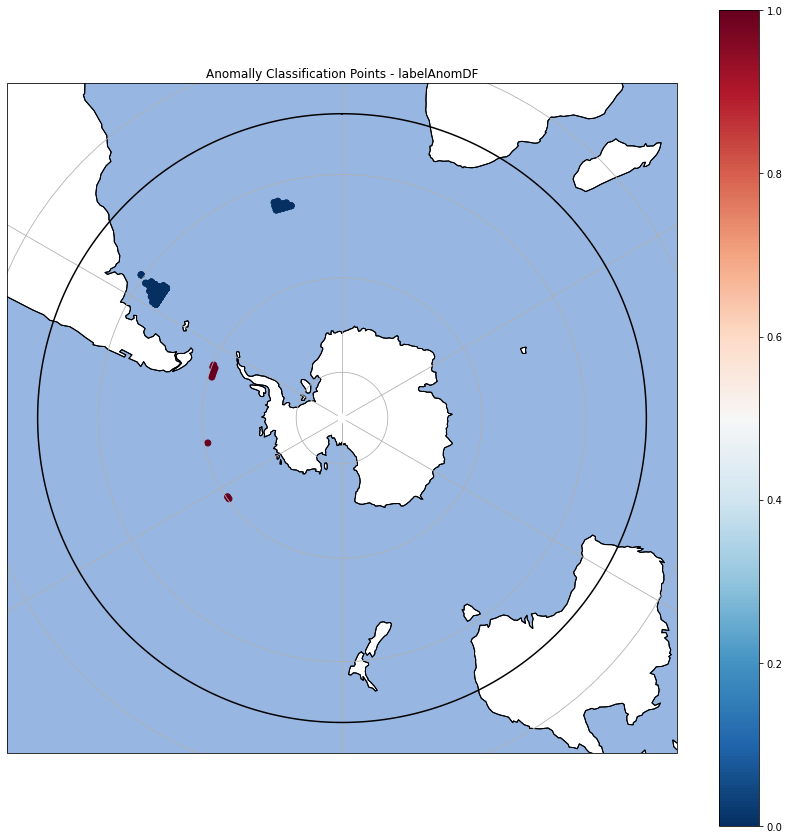

In [22]:
labelAnomDF = sampleMetaDFL[np.logical_or(np.logical_and(sampleMetaDFL["lat"]<-60, sampleMetaDFL["labelSorted"]==1), np.logical_and(sampleMetaDFL["lat"]>-45, sampleMetaDFL["labelSorted"]==0))]
print("Class 0 above -45 and Class 1 below -60 lat. Stored in labelAnomDF. "+str(len(labelAnomDF))+" anomalous points detected.")
locationPlotGroupDFLab(labelAnomDF, "Anomally Classification Points - labelAnomDF", (15,15), 1)

In [23]:
antarcticAnomDF = sampleMetaDFL[np.logical_and(np.logical_and(sampleMetaDFL["labelSorted"]==1, sampleMetaDFL["lat"]<-65), np.logical_and(sampleMetaDFL["lon"]>-60, sampleMetaDFL["lon"]<70))]
antarcticLen = len(antarcticAnomDF)
if antarcticLen:
    locationPlotGroupDFLab(antarcticAnomDF, "Specific Anomally Classification Points - antarcticAnomDF", (15,15), 1)
print(str(antarcticLen)+" Antarctic anomalous samples found (Lat<-65, Lon<70, Lon>-60.")
plt.show()

0 Antarctic anomalous samples found (Lat<-65, Lon<70, Lon>-60.


<br>

### Average location information

In [24]:
#Average classification per location cell
averageGeoG = sampleMetaDFL.groupby(["lat", "lon"])
averageGeo = averageGeoG.mean(["lat", "lon"])
averageGeo = averageGeo.reset_index()
print("Average location information calculated and stored in averageGeo.")

Average location information calculated and stored in averageGeo.


In [25]:
#Average classification per location and month cell
averageMonthGeoG = sampleMetaDFL.groupby([sampleMetaDFL.time.dt.month, "lat", "lon"])
averageMonthGeo = averageMonthGeoG.mean(["lat", "lon"])
averageMonthGeo = averageMonthGeo.reset_index()
print("Average monthly location information calculated and stored in averageMonthGeo.")

Average monthly location information calculated and stored in averageMonthGeo.


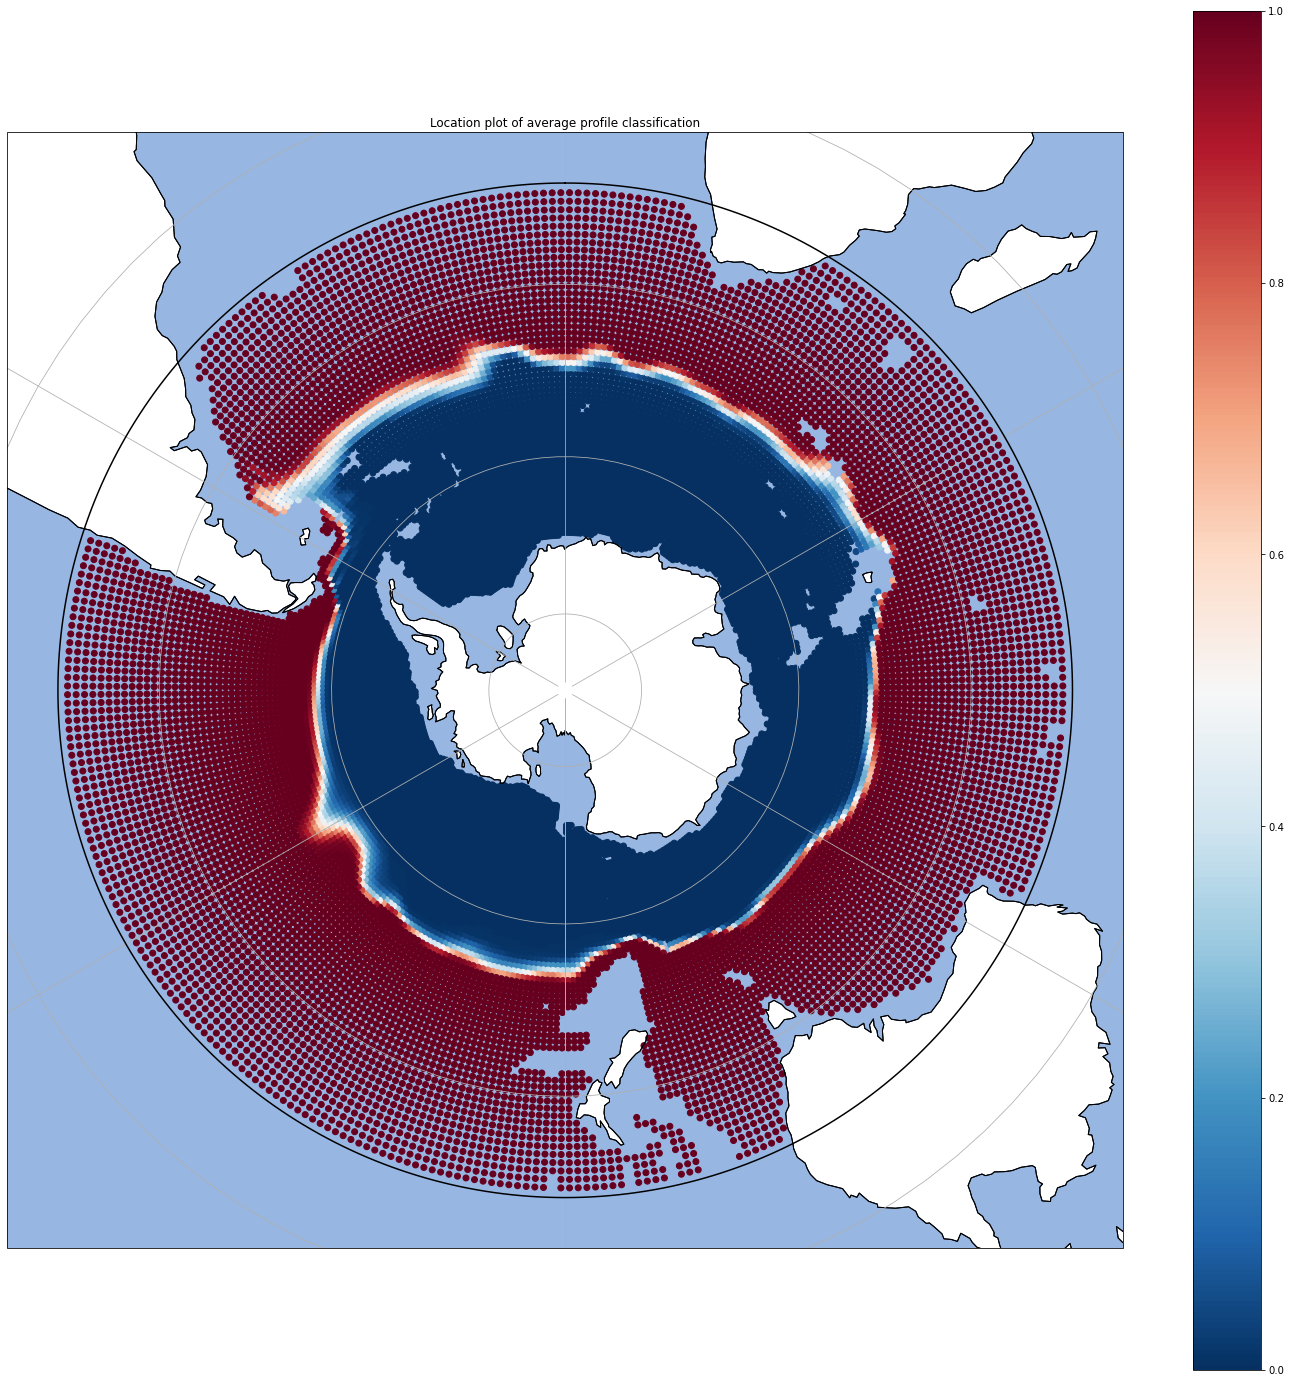

In [26]:
#Average classification location plot cell
locationPlotGroupDFLab(averageGeo, "Location plot of average profile classification", (25,25), 1)
plt.show()

Average Classifications, grouped by month.


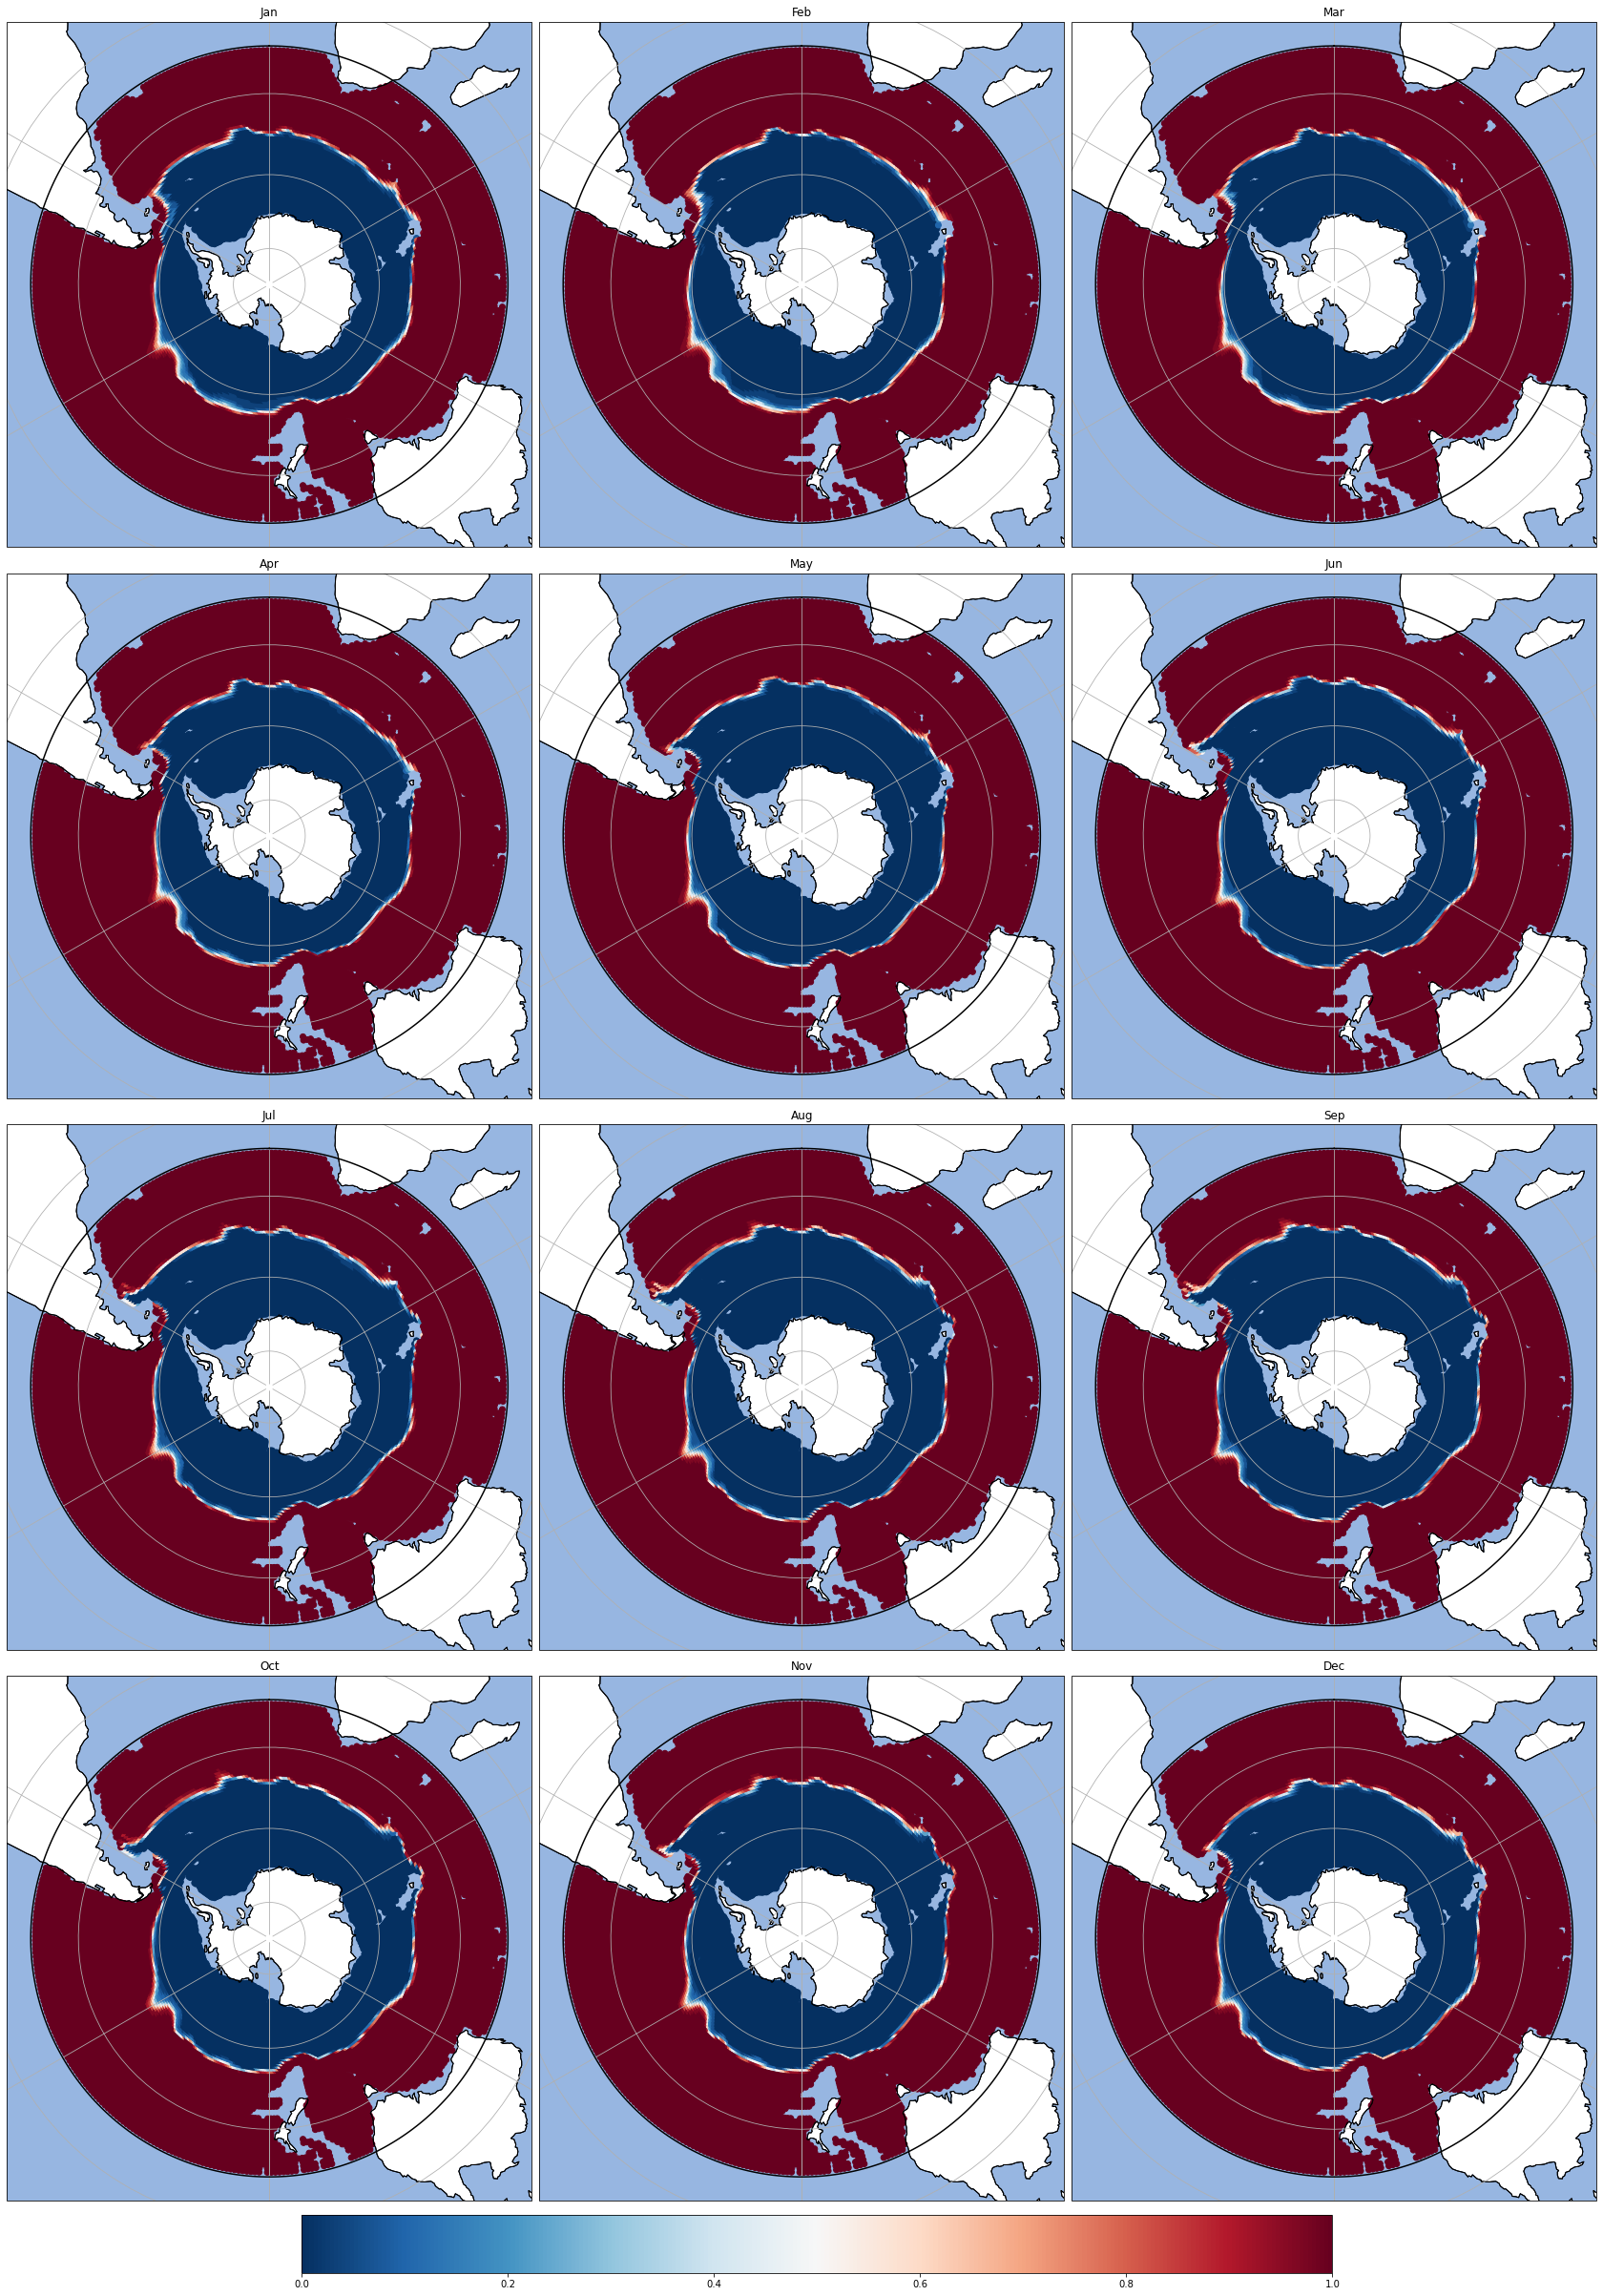

In [27]:
locationPlotGroupDFMonthly(averageMonthGeo, "Monthly summaries for training data set", 1)
print("Average Classifications, grouped by month.")
plt.show()

Average Uncertainty in classifications, grouped by month.


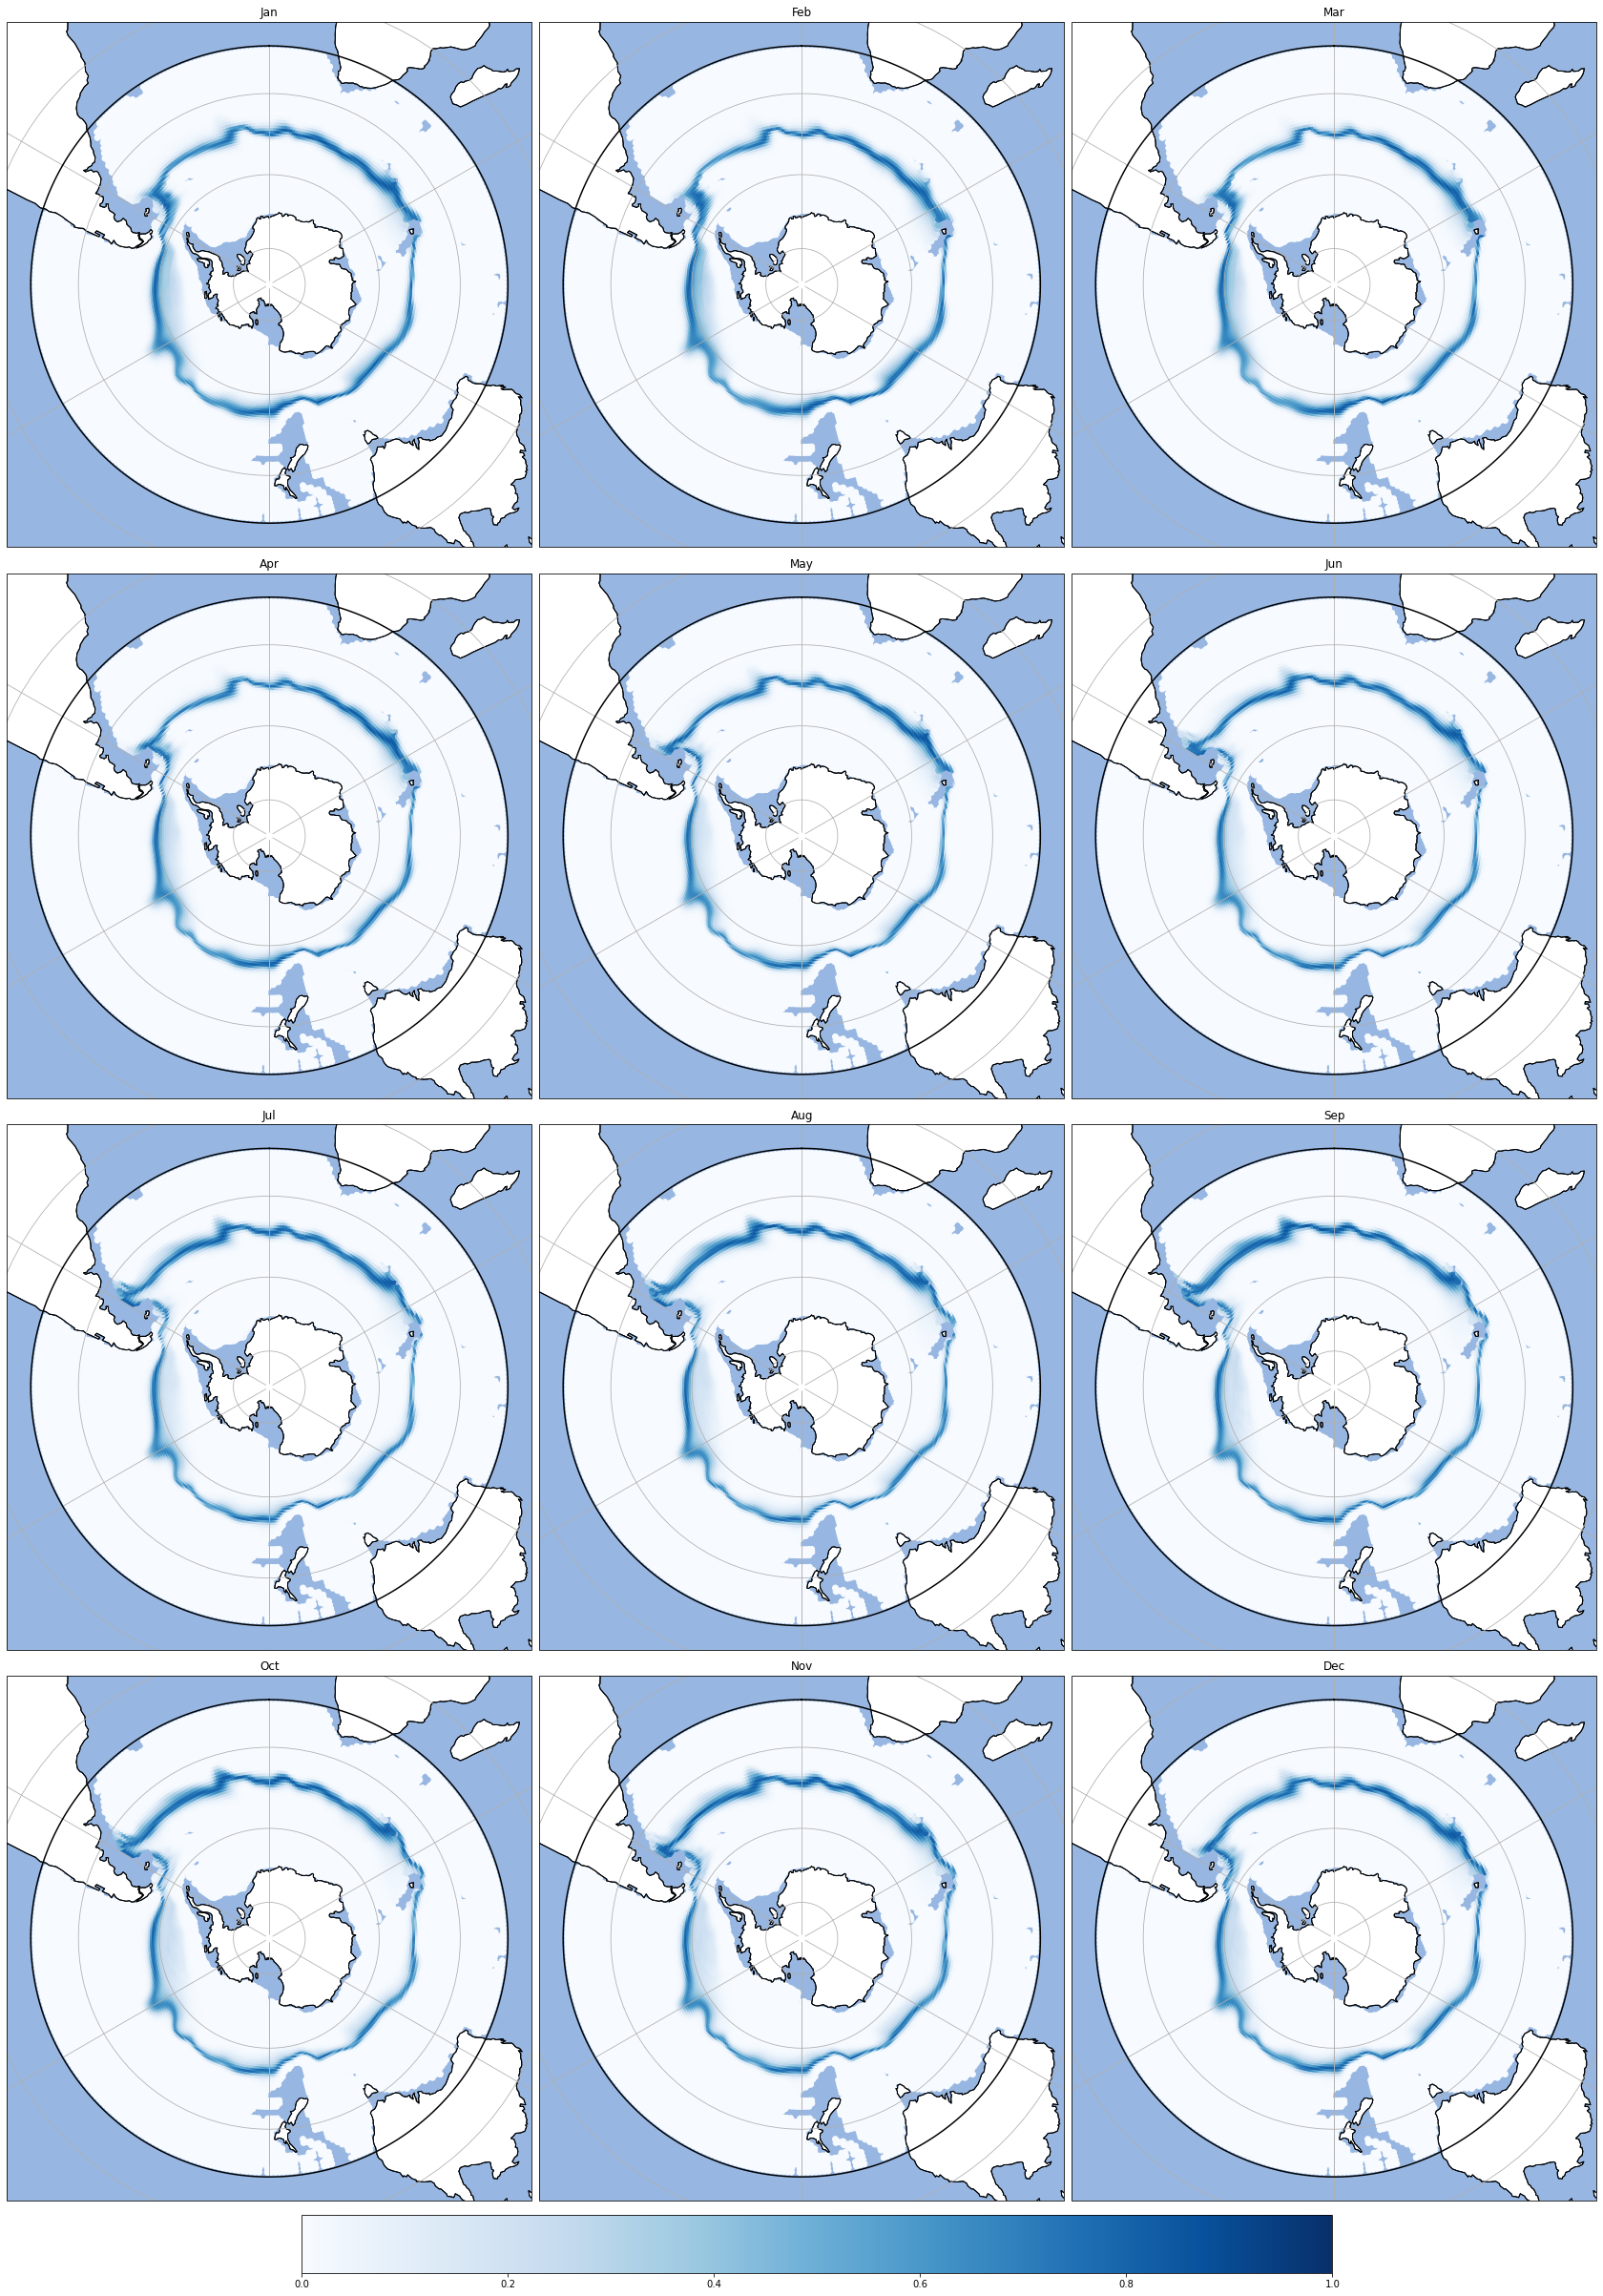

In [28]:
locationPlotUncertaintyDFMonthly(averageMonthGeo, "Monthly uncertainty", 1)
print("Average Uncertainty in classifications, grouped by month.")
plt.show()

<br>

### Single Month Properities

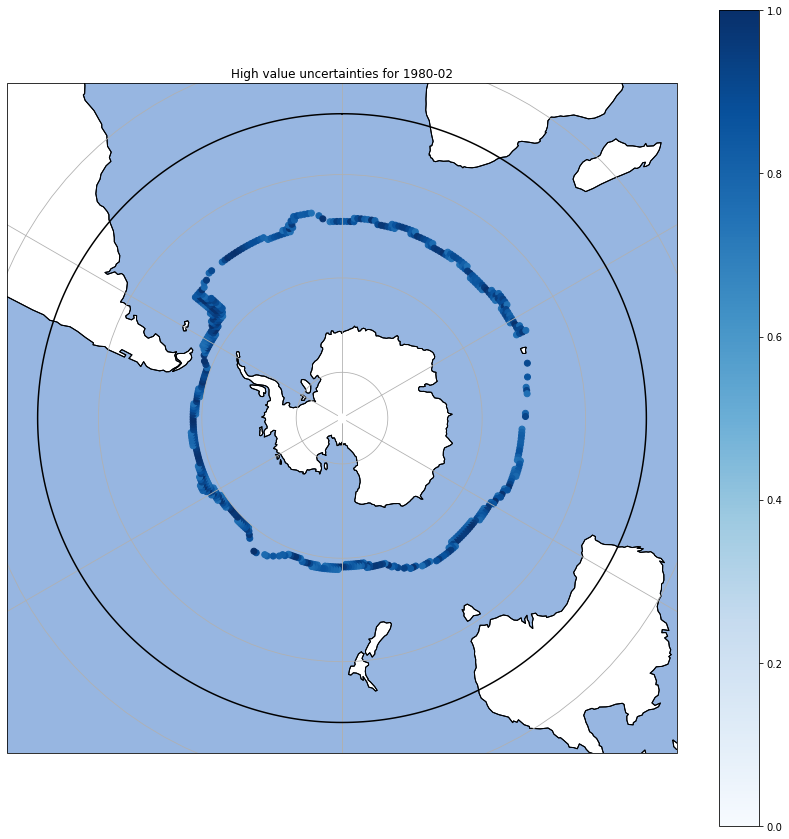

Single Month data identified and plotted and stored in monthlyData. 534 high classification uncertainty points identified.


In [29]:
testTime = "1980-02"
uncertaintyDFL = sampleMetaDFL[sampleMetaDFL["classUncertainty"] > 0.75]
monthlyData = uncertaintyDFL[uncertaintyDFL["time"]=="1980-02"]#["lon"].unique()
locationPlotUncertaintyDF(monthlyData, "High value uncertainties for "+testTime, (15,15), 1)
plt.show()
print("Single Month data identified and plotted and stored in monthlyData. "+str(len(monthlyData))+" high classification uncertainty points identified.")

<br>

### Mean Singular Latitudes over time

In [30]:
thresholds = [0.25, 0.50, 0.75, 0.85]
smoothFactor1 = 24
smoothFactor2 = 120
monthlyLatMMList = []
monthlyLatMMS1List = []
monthlyLatMMS2List = []

for i in range(len(thresholds)):
    uncertaintyDFL = sampleMetaDFL[sampleMetaDFL["classUncertainty"] > thresholds[i]]
    
    uncertaintyDFLLonTimeG = uncertaintyDFL.groupby(["lon","time"])
    uncertaintyDFLLonM = uncertaintyDFLLonTimeG.mean("lon")
    uncertaintyDFLLonM = uncertaintyDFLLonM.reorder_levels(['time', 'lon']).sort_index()
    uncertaintyDFLLonMTimeG = uncertaintyDFLLonM.groupby("time")
    
    monthlyLatMMList.append(uncertaintyDFLLonMTimeG.mean()[["lat"]])
    monthlyLatMMS1List.append(butter_lowpass(monthlyLatMMList[i]["lat"], smoothFactor1))
    monthlyLatMMS2List.append(butter_lowpass(monthlyLatMMList[i]["lat"], smoothFactor2))
print("Monthly Singular Mean Latitudes calculated, with smoothing.")

Monthly Singular Mean Latitudes calculated, with smoothing.


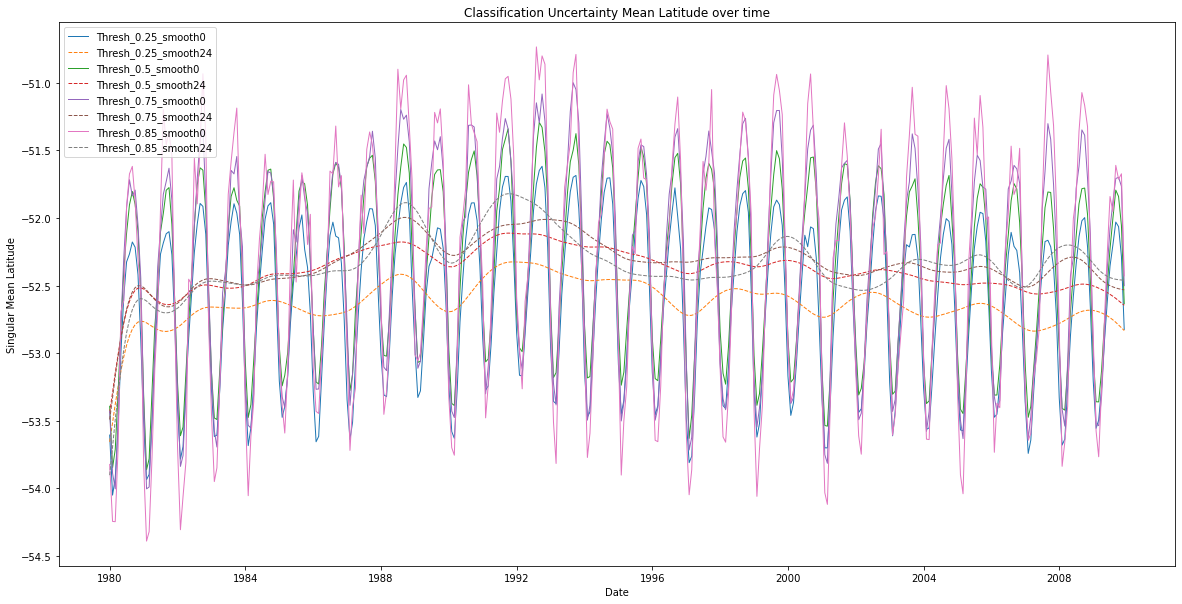

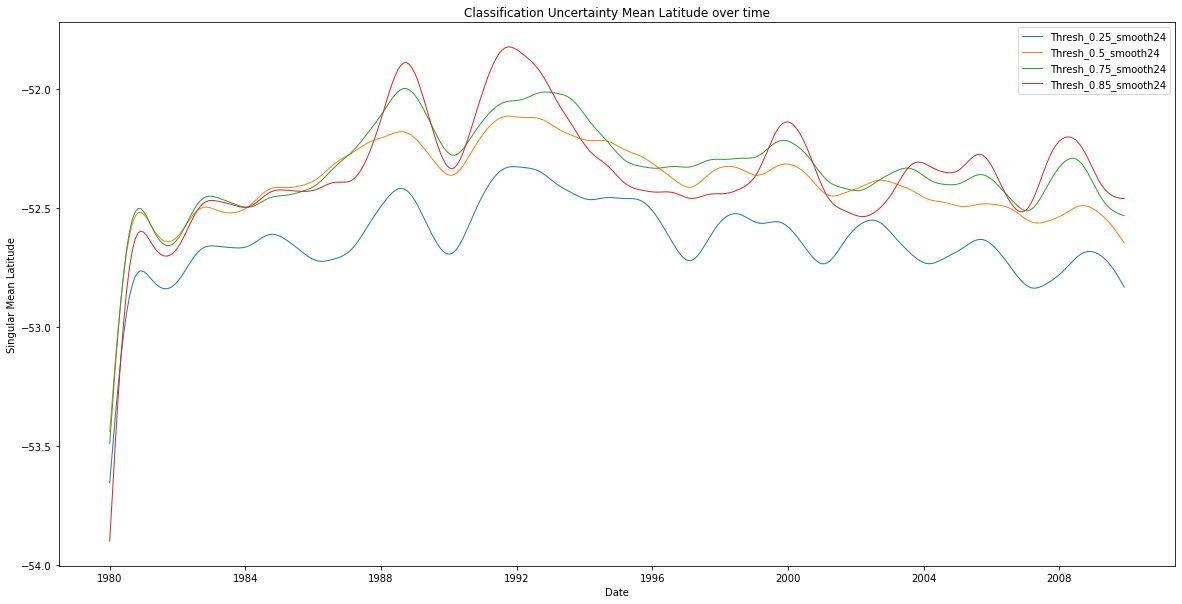

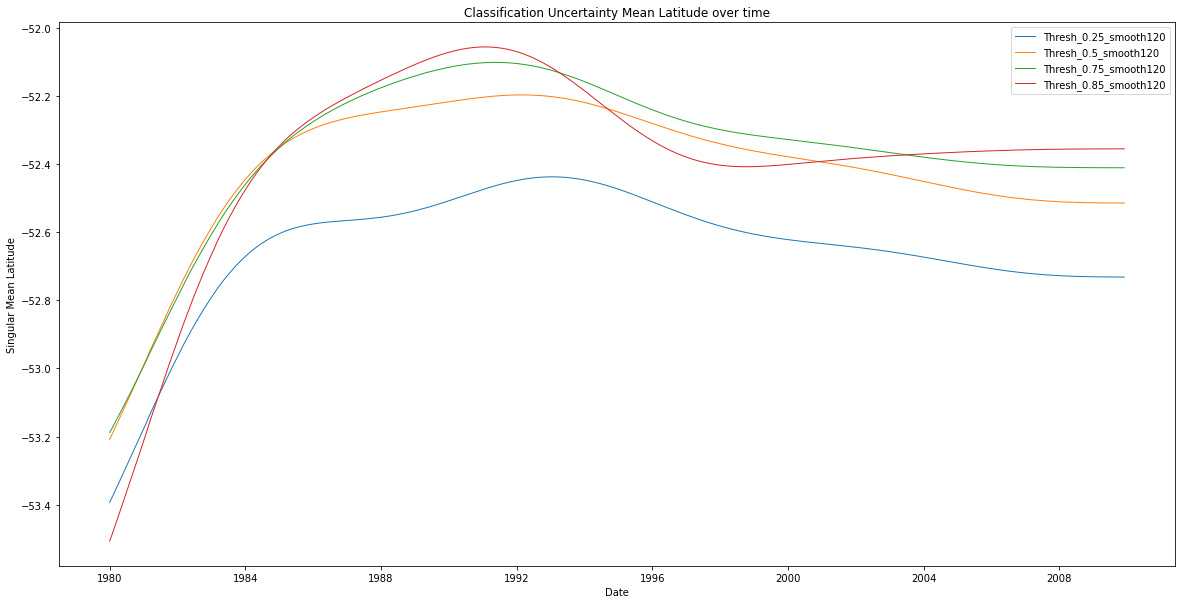

In [31]:
for i in range(len(thresholds)):
    timeSingleLatMean(monthlyLatMMList[i], "-", thresholds[i], 0, 1)
    timeSingleLatMean(monthlyLatMMS1List[i], "--", thresholds[i], smoothFactor1, 1)
    
    timeSingleLatMean(monthlyLatMMS1List[i], "-", thresholds[i], smoothFactor1, 2)
    timeSingleLatMean(monthlyLatMMS2List[i], "-", thresholds[i], smoothFactor2, 3)
    
for i in range(1, 4):    
    plt.figure(i)
    #plt.gca().invert_yaxis()

plt.show()

<br>

### 1997 Dip investigation

Single Lat mean value for 1994 to 1998


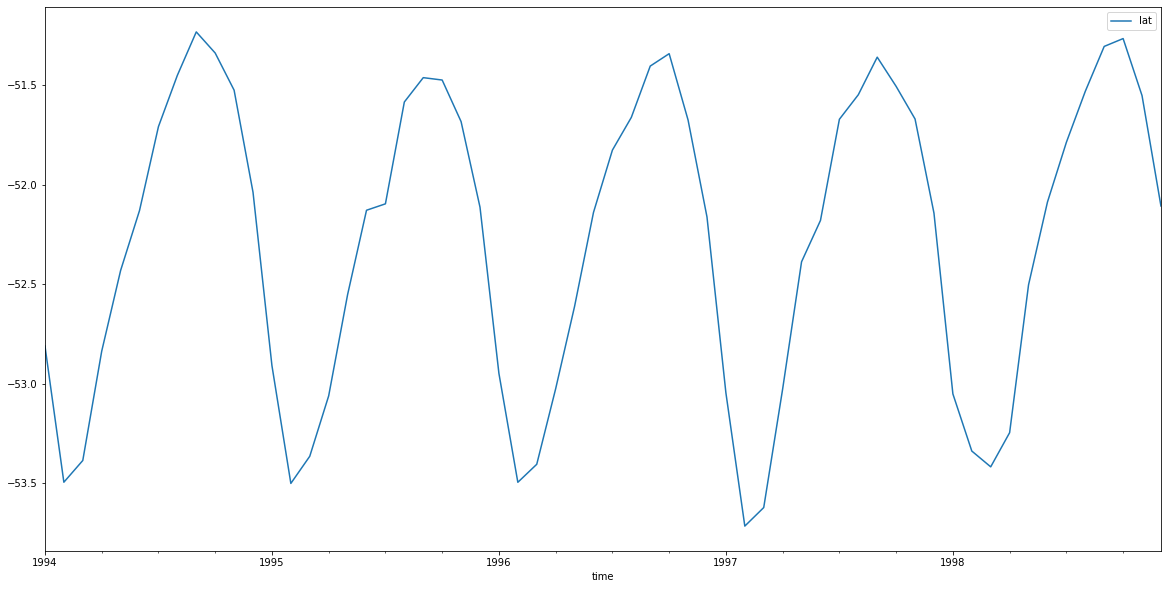

In [32]:
timeRange = np.arange(np.datetime64("1994-01",'M'), np.datetime64("1999-01", 'M'), np.timedelta64(1, 'M'))
breakDown = monthlyLatMMList[2]
timeRangeDF = breakDown[breakDown.index.isin(timeRange)]
timeRangeDF.plot(figsize=(20,10))
print("Single Lat mean value for 1994 to 1998")
plt.show()

In [33]:
timeRangeClose = np.arange(np.datetime64("1996-01",'M'), np.datetime64("1998-01", 'M'), np.timedelta64(1, 'M'))
timeRangeCloseDF = sampleMetaDFL[sampleMetaDFL["time"].isin(timeRangeClose)]
avgGeoTimeRangeCloseDFG = timeRangeCloseDF.groupby(["lat", "lon"])
avgGeoTimeRangeCloseDF = avgGeoTimeRangeCloseDFG.mean(["lat", "lon"])
avgGeoTimeRangeCloseDF = avgGeoTimeRangeCloseDF.reset_index()
print("Average classification information calculated for 1996 - 1997, stored in avgGeoTimeRangeCloseDF.")

Average classification information calculated for 1996 - 1997, stored in avgGeoTimeRangeCloseDF.


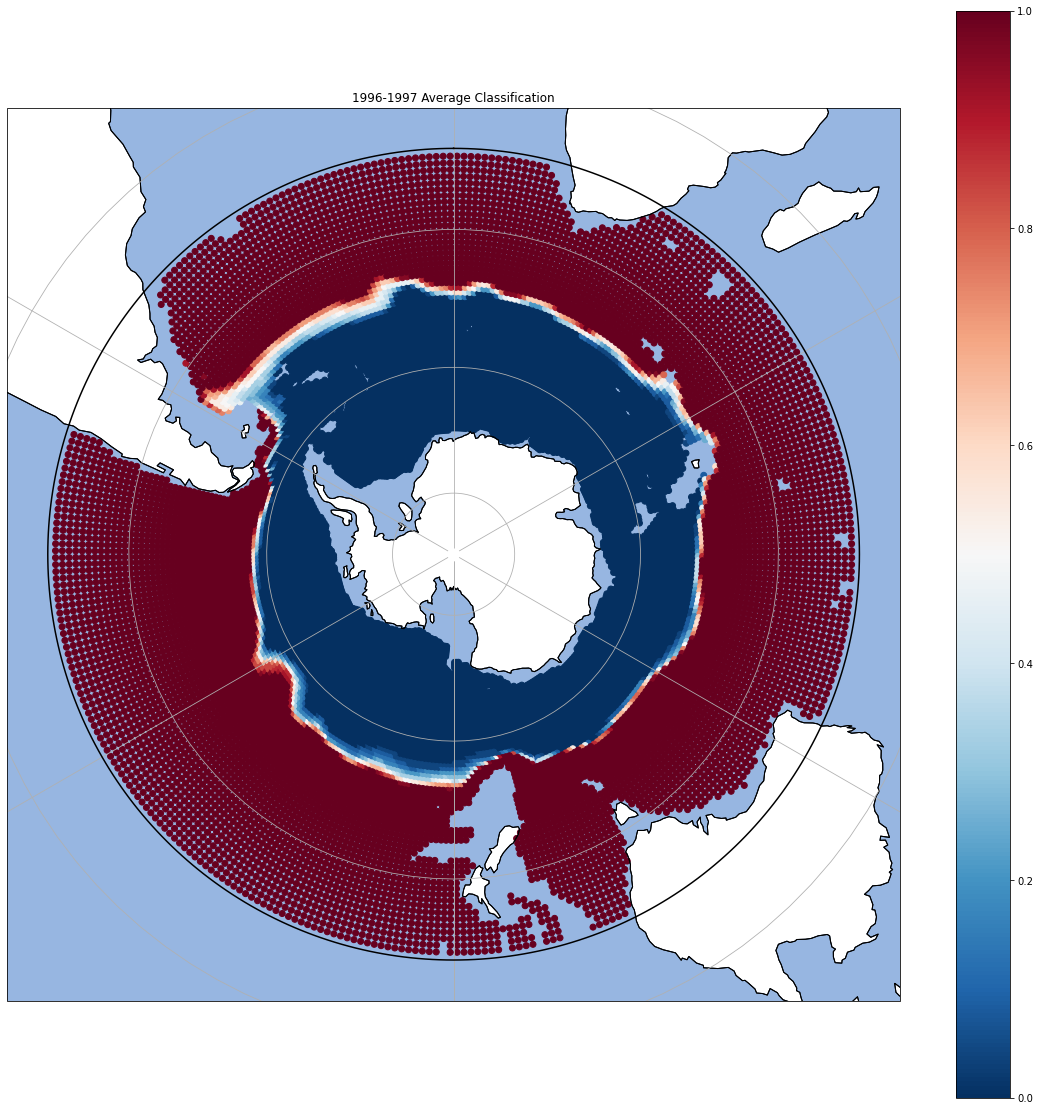

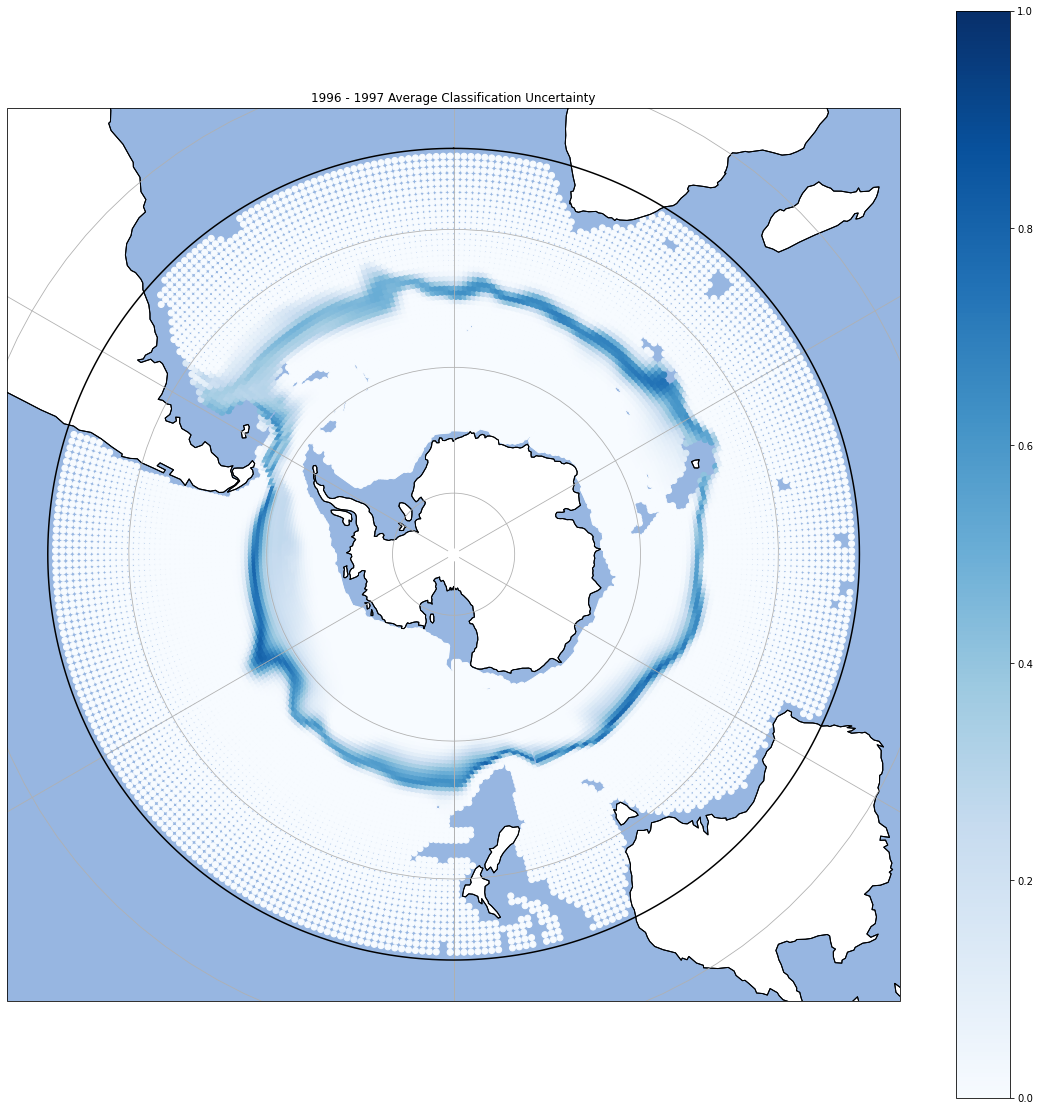

In [34]:
locationPlotGroupDFLab(avgGeoTimeRangeCloseDF, "1996-1997 Average Classification", (20,20), 1) #timeRangeCloseDF
locationPlotUncertaintyDF(avgGeoTimeRangeCloseDF, "1996 - 1997 Average Classification Uncertainty", (20,20), 2)
plt.show()

<br>

### Decadal investigation

In [35]:
decades = ["1980", "1990", "2000"]
decade80 = np.arange(np.datetime64("1980", 'M'), np.datetime64("1990", 'M'), np.timedelta64(1, 'M'))
decade90 = np.arange(np.datetime64("1990", 'M'), np.datetime64("2000", 'M'), np.timedelta64(1, 'M'))
decade00 = np.arange(np.datetime64("2000", 'M'), np.datetime64("2010", 'M'), np.timedelta64(1, 'M'))
decadeList = [decade80, decade90, decade00]
print("Decade lists created and stored in decade80, decade90 and decade00.")

Decade lists created and stored in decade80, decade90 and decade00.


In [36]:
sampleMetaDFDecList = [sampleMetaDFL[sampleMetaDFL["time"].isin(decade80)], sampleMetaDFL[sampleMetaDFL["time"].isin(decade90)], sampleMetaDFL[sampleMetaDFL["time"].isin(decade00)]]
print("Decade split performed and stored in sampleMetaDFDecList.")

Decade split performed and stored in sampleMetaDFDecList.


In [37]:
decDFIThreshList = []
decDFIThreshLatMList = []
decDFIThreshLatSList = []
threshold = 0.75

for i in range(len(decades)):
    decDF = sampleMetaDFDecList[i]
    decDFIThresh = decDF[decDF["classUncertainty"] > threshold]
    decDFIThreshList.append(decDFIThresh)
    
    decDFIThreshLonG = decDFIThresh.groupby("lon")
    decDFIThreshLatMList.append(decDFIThreshLonG.mean()[["lat"]])
    decDFIThreshLatSList.append(decDFIThreshLonG.std()[["lat"]])
print("Decadal class uncertainty latitude means calculted and stored in decDFIThreshLatMList. Standard deviations are stored in decDFIThreshLatSList.")

Decadal class uncertainty latitude means calculted and stored in decDFIThreshLatMList. Standard deviations are stored in decDFIThreshLatSList.


In [38]:
decDFIThreshLatMMListDecade = []
decDFIThreshLatMMListYearly = []
for i in range(len(decDFIThreshLatMList)):
    decDFIThreshLatMMListDecade.append(decDFIThreshLatMList[i]["lat"].mean()) #Decadal Mean (time->lon)
    
    yearlyLatMeans = monthlyLatMMList[2]
    decadeSet = yearlyLatMeans[yearlyLatMeans.index.isin(decadeList[i])]
    decDFIThreshLatMMListYearly.append(decadeSet["lat"].mean()) #Yearly Mean from previous sections (lon->time)
    
    print("For "+str(decades[i])+" the singular mean latitude for a threshold of "+str(threshold)+" was "+str(np.round(decDFIThreshLatMMListDecade[i], 2))+" via decade and "+str(np.round(decDFIThreshLatMMListYearly[i], 2))+" via yearly.")
print("Decade singular mean latitude values calculated.")

For 1980 the singular mean latitude for a threshold of 0.75 was -52.37 via decade and -52.39 via yearly.
For 1990 the singular mean latitude for a threshold of 0.75 was -52.17 via decade and -52.2 via yearly.
For 2000 the singular mean latitude for a threshold of 0.75 was -52.39 via decade and -52.39 via yearly.
Decade singular mean latitude values calculated.


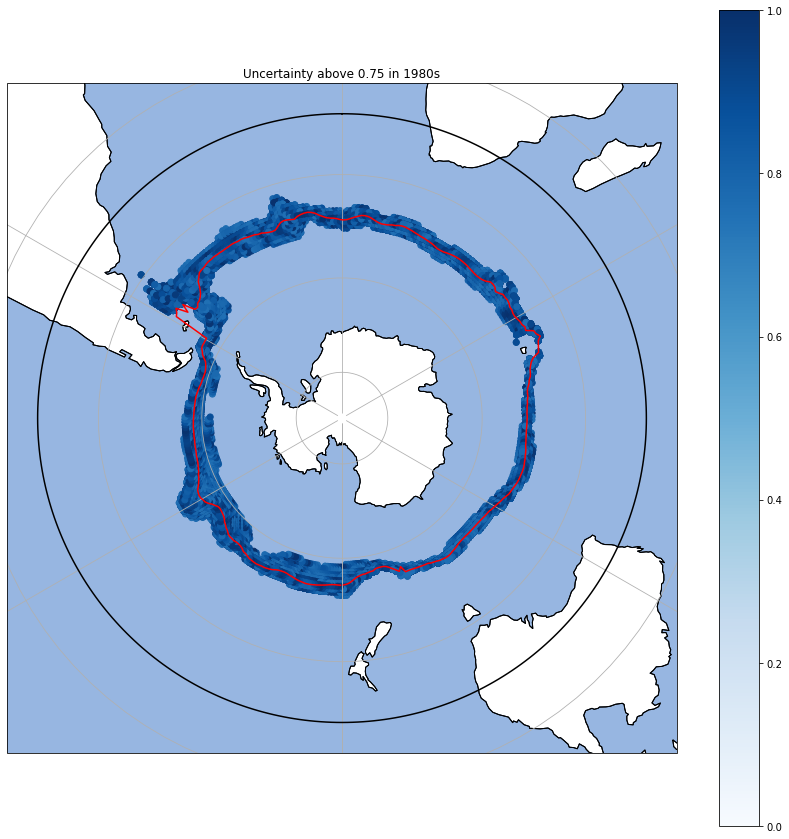

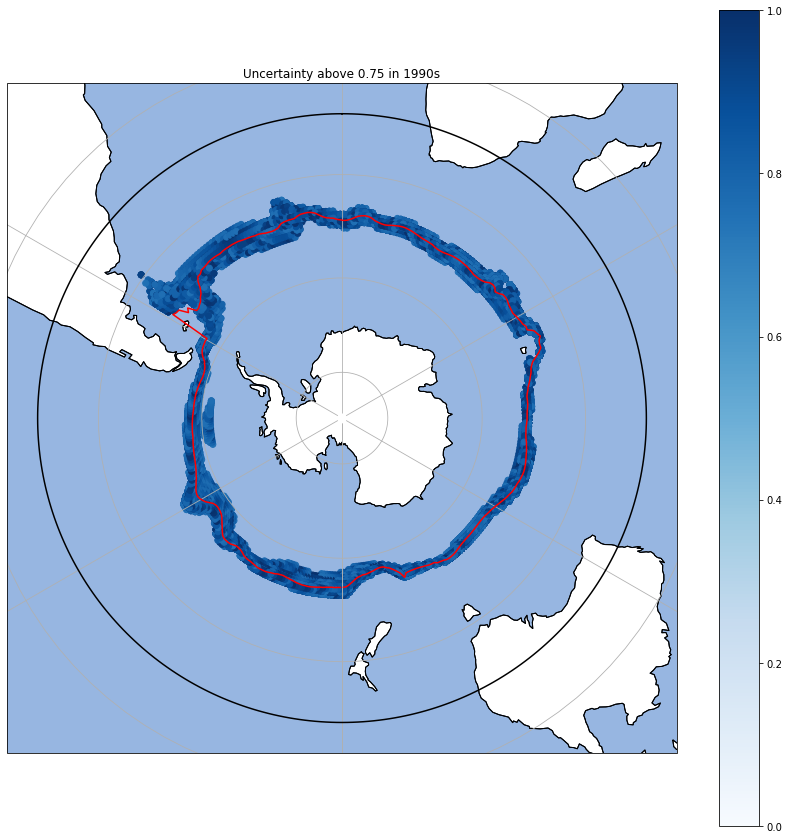

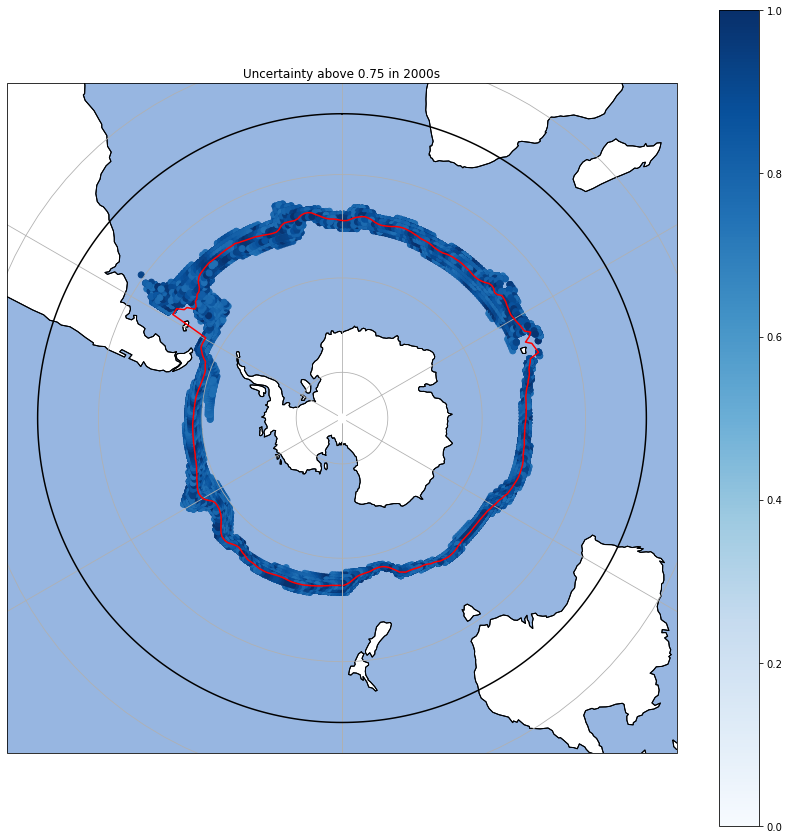

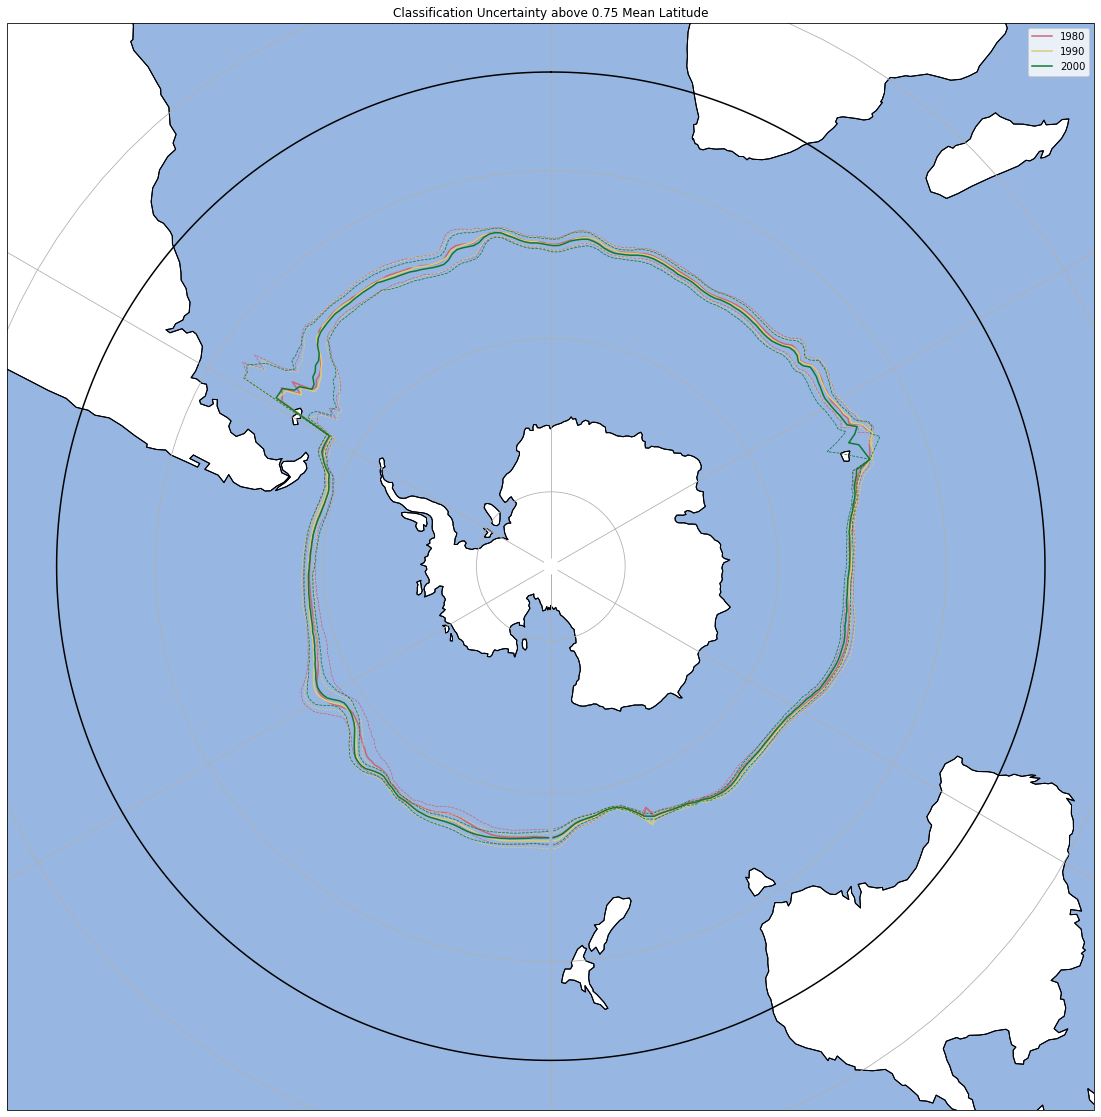

In [39]:
for i in range(len(decades)):    
    locationPlotUncertaintyDF(decDFIThreshList[i], "Uncertainty above "+str(threshold)+" in "+decades[i]+"s", (15,15), i)
    plt.plot(decDFIThreshLatMList[i].index, decDFIThreshLatMList[i]["lat"], transform=ccrs.PlateCarree(), color="red")
    
locationUncertaintyMean(decDFIThreshLatMList, decDFIThreshLatSList, threshold, (20,20), 4)
plt.show()

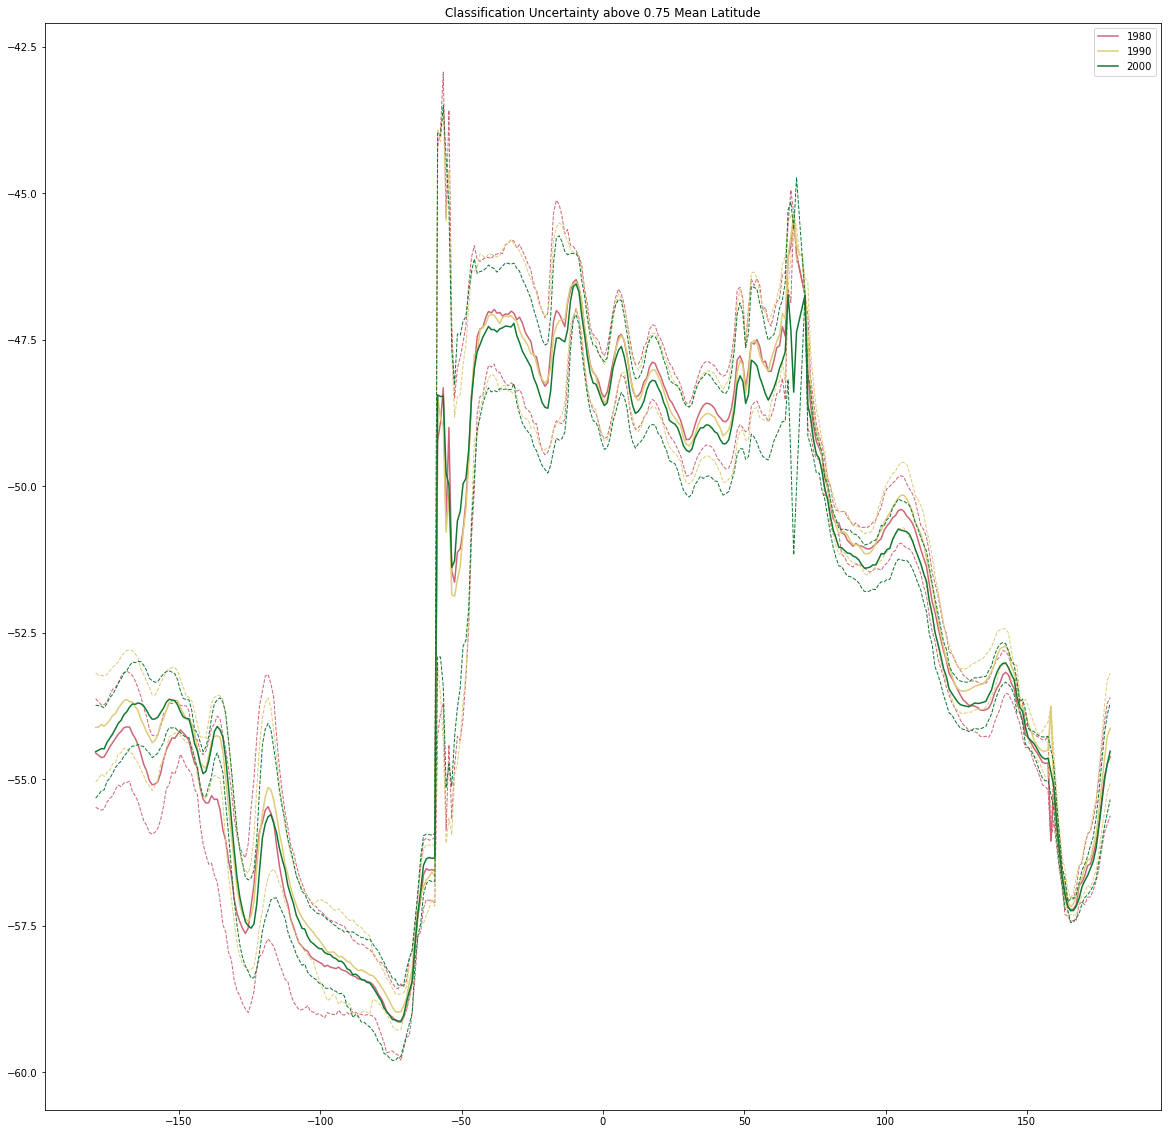

In [40]:
locationUncertaintyMeanCart(decDFIThreshLatMList, decDFIThreshLatSList, threshold, (20,20), 1)
plt.show()

<br>

### Exporting Monthly Latitude Means

In [41]:
exportName = modelName + "_LatMeans"
np.save(exportName, monthlyLatMMList)
print("Monthly Latitude means (monthlyLatMMList) exported to "+exportName+".")

Monthly Latitude means (monthlyLatMMList) exported to GMM_UK_2Class_R3_v2_LatMeans.


In [42]:
importName = exportName+".npy"
monthlyLatMMListReload = np.load(importName)
print("Monthly Latitude means reloaded into monthlyLatMMListReload from "+importName+".")

Monthly Latitude means reloaded into monthlyLatMMListReload from GMM_UK_2Class_R3_v2_LatMeans.npy.


In [43]:
print("Reloaded monthly latitude means.")
monthlyLatMMList

Reloaded monthly latitude means.


[                  lat
 time                 
 1980-01-01 -53.605186
 1980-02-01 -54.048988
 1980-03-01 -53.923532
 1980-04-01 -53.540696
 1980-05-01 -52.997968
 ...               ...
 2009-08-01 -52.200197
 2009-09-01 -52.031156
 2009-10-01 -52.064855
 2009-11-01 -52.285808
 2009-12-01 -52.824674
 
 [360 rows x 1 columns],
                   lat
 time                 
 1980-01-01 -53.392420
 1980-02-01 -53.846527
 1980-03-01 -53.710886
 1980-04-01 -53.287785
 1980-05-01 -52.802768
 ...               ...
 2009-08-01 -52.003570
 2009-09-01 -51.795080
 2009-10-01 -51.841820
 2009-11-01 -52.057901
 2009-12-01 -52.634595
 
 [360 rows x 1 columns],
                   lat
 time                 
 1980-01-01 -53.429640
 1980-02-01 -53.887248
 1980-03-01 -54.002583
 1980-04-01 -53.490542
 1980-05-01 -52.782657
 ...               ...
 2009-08-01 -51.883222
 2009-09-01 -51.709261
 2009-10-01 -51.700797
 2009-11-01 -51.766722
 2009-12-01 -52.501435
 
 [360 rows x 1 columns],
                   lat

### End of Notebook